In [ ]:
#13 June 2022 
#setpoint rsc_rxs_tempvac_temp15k from 20 to 21k

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import requests # Could use the builtin urllib but Requests are nicer.
from requests.exceptions import ConnectionError
import katpoint
import time
import pandas as pd
import csv
import re

%pylab inline
%autosave 60

Populating the interactive namespace from numpy and matplotlib


Autosaving every 60 seconds


In [3]:
url="http://portal.mkat.karoo.kat.ac.za/katstore/api/query" # site for the most resent values
#url='http://kat-flap-cpt.mkat.control.kat.ac.za/katstore/samples' # flap in CT for older values

In [4]:
url_rts="http://portal.mkat-rts.karoo.kat.ac.za/katstore/api/query" # site for the most resent values
#url='http://kat-flap-cpt.mkat.control.kat.ac.za/katstore/samples' # flap in CT for older values

In [5]:
sensors = [
#    'rsc_rxl_state',
    ['anc_weather_temperature', 50,'gt'],
    ['rsc_rsc_he_compressor_supply_pressure', 18,'lt'],
    ['rsc_rsc_he_compressor_temperature1', 60,'gt'],
    ['rsc_rxs_tempvac_temp15k', 21,'gt'],
    ['rsc_rxs_cryocooler_motorspeedmeasure', 75,'gt'],
    ['rsc_rxs_tempvac_temp70k', 65,'gt']
    ]

In [6]:
aps = []
for i in range(64):
    aps.append('m'+str(i).zfill(3))

In [7]:
rts = []
# Add RTS in Example rts = ['m028,M034']

In [8]:
for r in rts:
    ind = aps.index(r)
    aps.pop(ind)

In [9]:
now = time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime(time.time()))
def_start = katpoint.Timestamp(time.time()-8*24*3600)
def_end = katpoint.Timestamp(now)


all_data = {}        
for ap in aps:
    all_data[ap] = {}
    st =  time.time()
    len_rec = 0
    for i,sensor in enumerate(sensors): 
        sen = '%s_%s'%(ap,sensor[0]) if sensor[0].startswith('rsc') else '%s'%(sensor[0])  
        
        params={'sensor': sen,  # name of the sensor.
           'start_time':def_start.secs, # start time in seconds - float should work.
           'end_time': def_end.secs, # end time in seconds
           'limit':1000000,
           'include_value_time': True}
        for t in range(10):
            try:
                res = requests.get(url, params,timeout=200) # Make the call.
            except Exception as e:
                print e
                print "Retrying"
                continue
            break
        res.close()
        if  res.status_code != 200: 
            continue
        len_rec += len(res.json()['data'])
        data_list = [(r['value_time'], r['value']) for r in res.json()['data']]
        data = array(data_list)
        if len(data) !=0:
            err = any(data[:,1] >= sensor[1]) if sensor[2] == 'gt' else any(data[:,1] <= sensor[1])
            all_data[ap][sensor[0]] = {'ts':data[:,0],'data':data[:,1],'err':err}
    ed =  time.time()
    print "%s processed in %.2f seconds with %d records at %s"%(ap,ed-st,len_rec,time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime(time.time())))

m000 processed in 9.73 seconds with 185574 records at 2021-03-04 07:50:59
m001 processed in 8.04 seconds with 173488 records at 2021-03-04 07:51:07
m002 processed in 8.55 seconds with 191017 records at 2021-03-04 07:51:15
m003 processed in 8.32 seconds with 189948 records at 2021-03-04 07:51:24
m004 processed in 8.45 seconds with 185334 records at 2021-03-04 07:51:32
m005 processed in 8.31 seconds with 186140 records at 2021-03-04 07:51:40
m006 processed in 8.25 seconds with 182122 records at 2021-03-04 07:51:49
m007 processed in 8.79 seconds with 202519 records at 2021-03-04 07:51:57
m008 processed in 8.94 seconds with 200835 records at 2021-03-04 07:52:06
m009 processed in 7.65 seconds with 159440 records at 2021-03-04 07:52:14
m010 processed in 8.98 seconds with 202994 records at 2021-03-04 07:52:23
m011 processed in 8.47 seconds with 187777 records at 2021-03-04 07:52:31
m012 processed in 7.91 seconds with 162229 records at 2021-03-04 07:52:39
m013 processed in 8.51 seconds with 18

In [10]:
sensors[0][0]

'anc_weather_temperature'

m000
m001
m002
m003
m004
m005
m006
m007
m008
m009
m010
m011
m012
m013
m014
m015
m016
m017
m018
m019
m020
m021
m022
m023
m024
m025
m026
m027
m028
m029
m030
m031
m032
m033
m034
m035
m036
m037
m038
m039
m040
m041
m042
m043
m044
m045
m046
m047
m048
m049
m050
m051
m052
m053
m054
m055
m056
m057
m058
m059
m060
m061
m062
m063


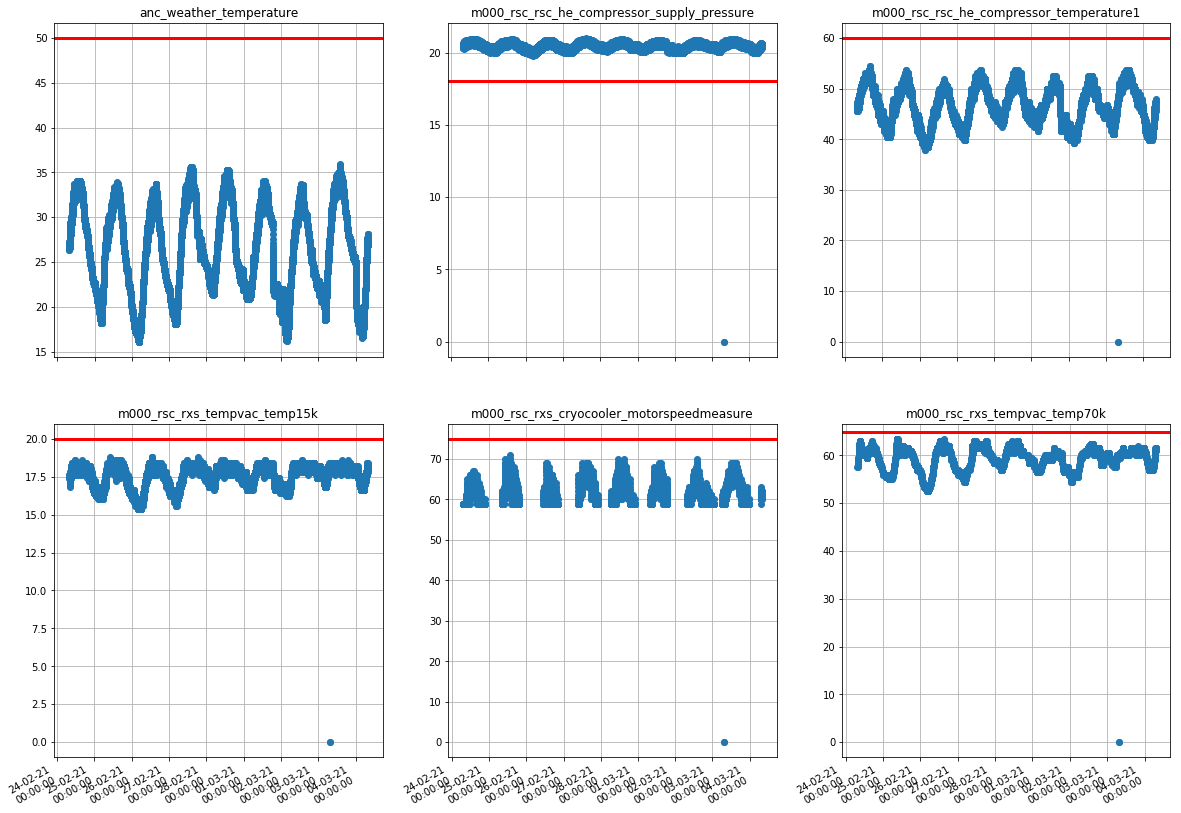

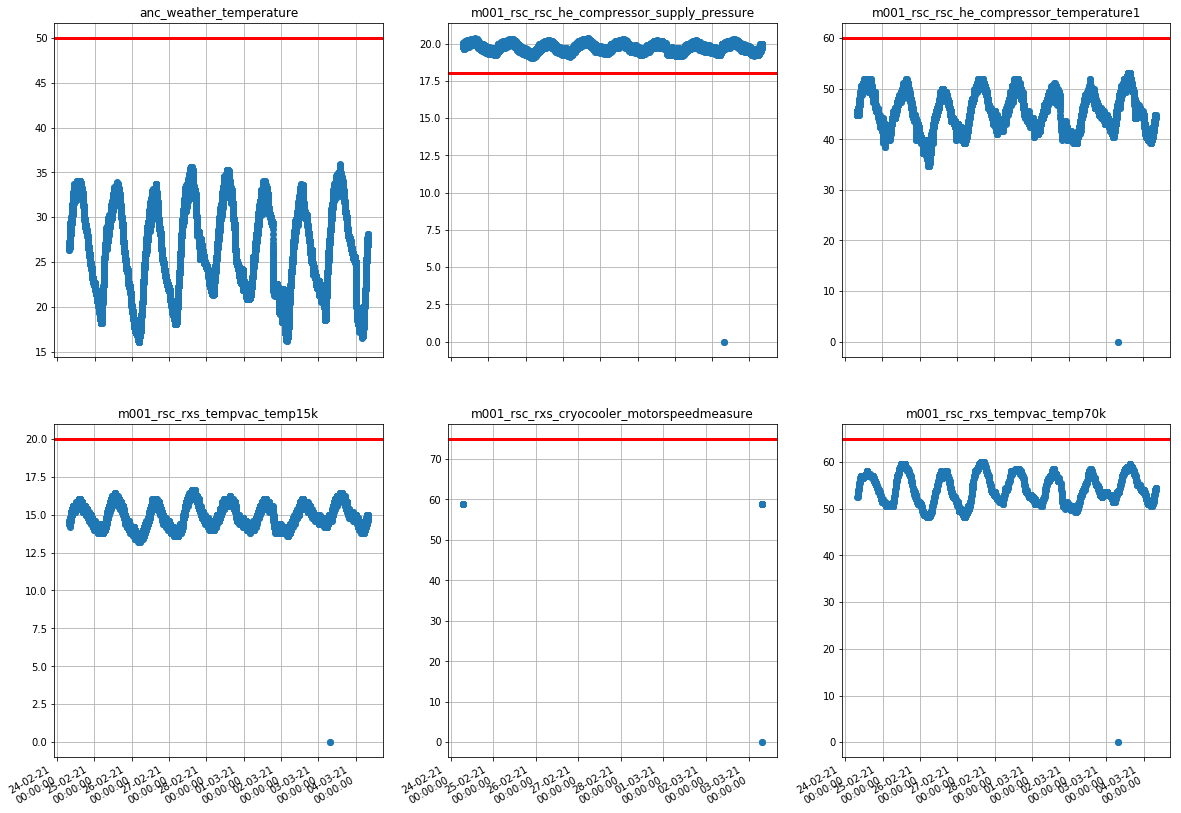

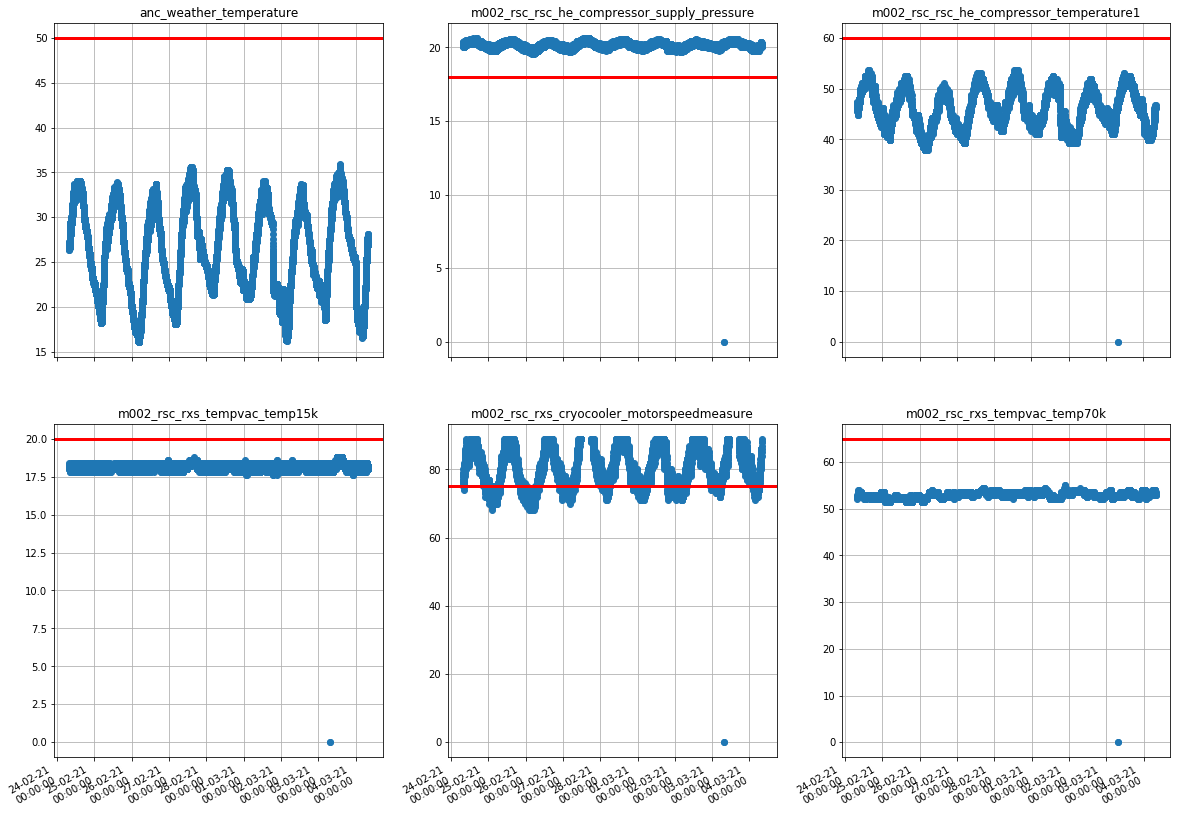

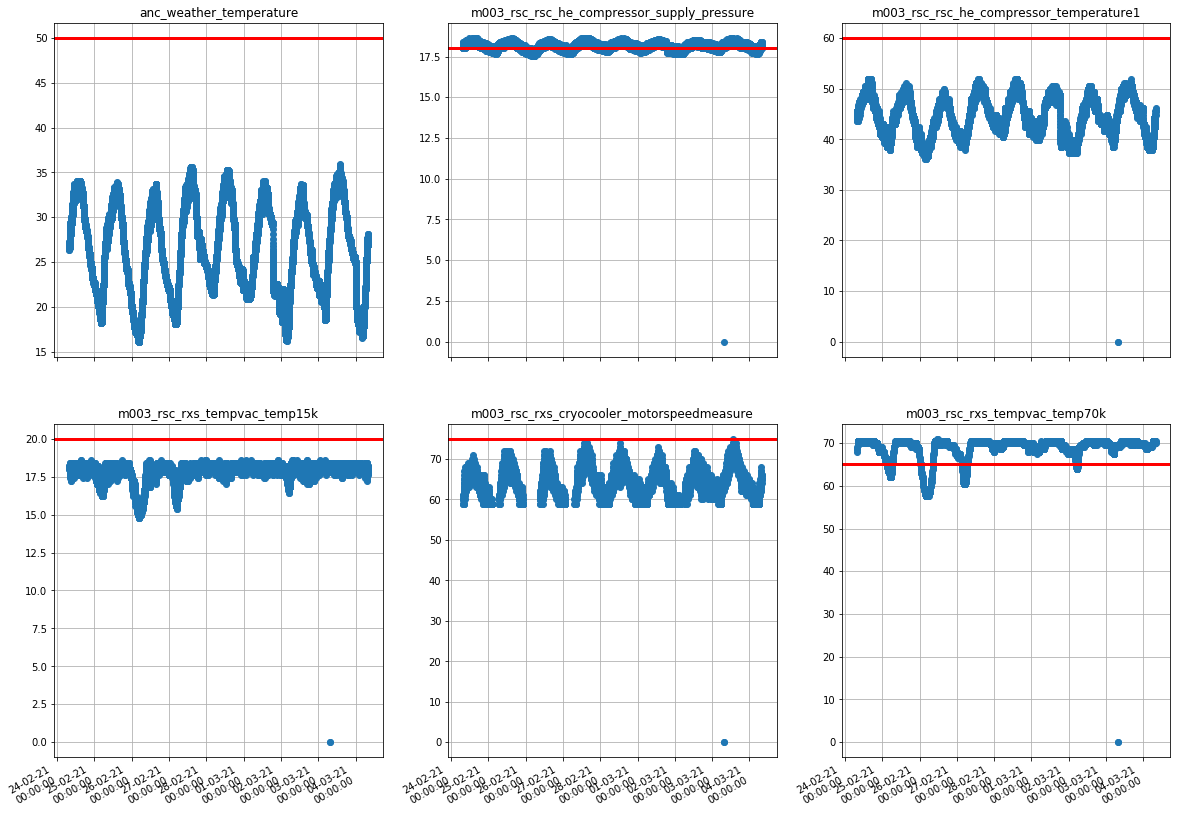

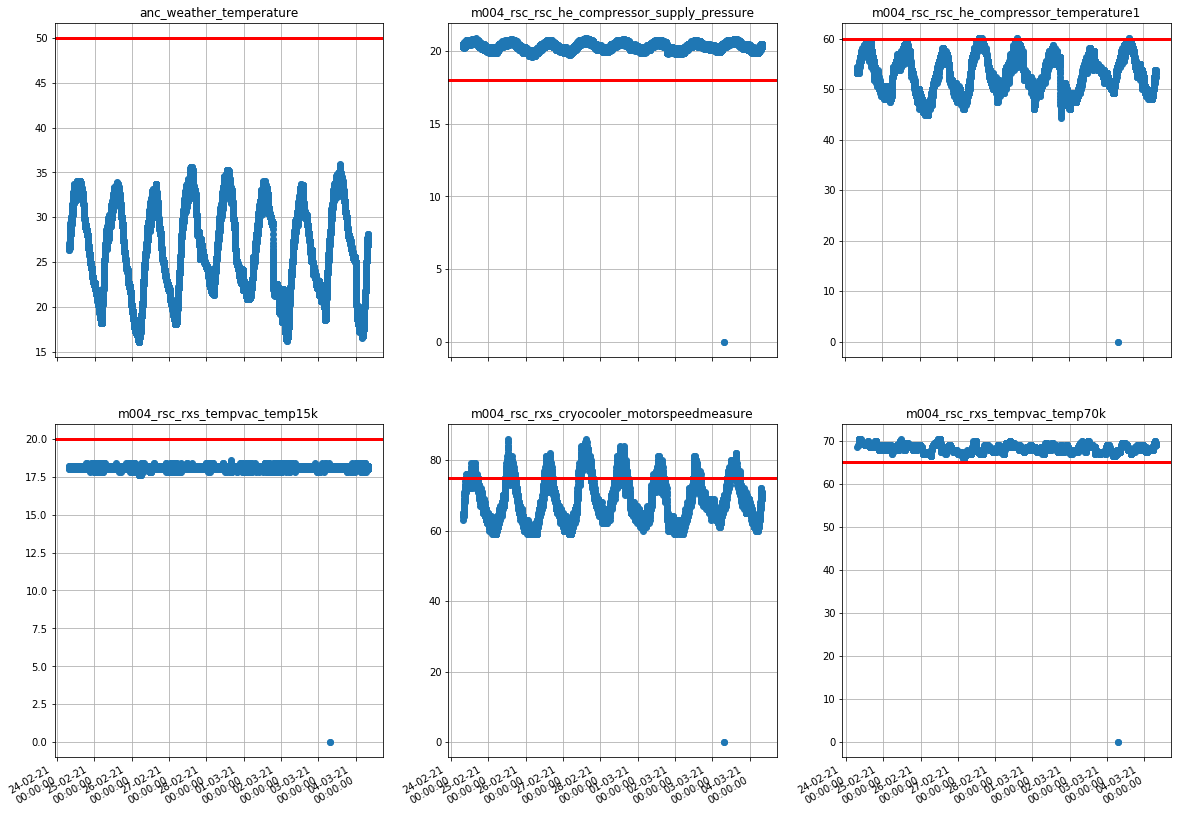

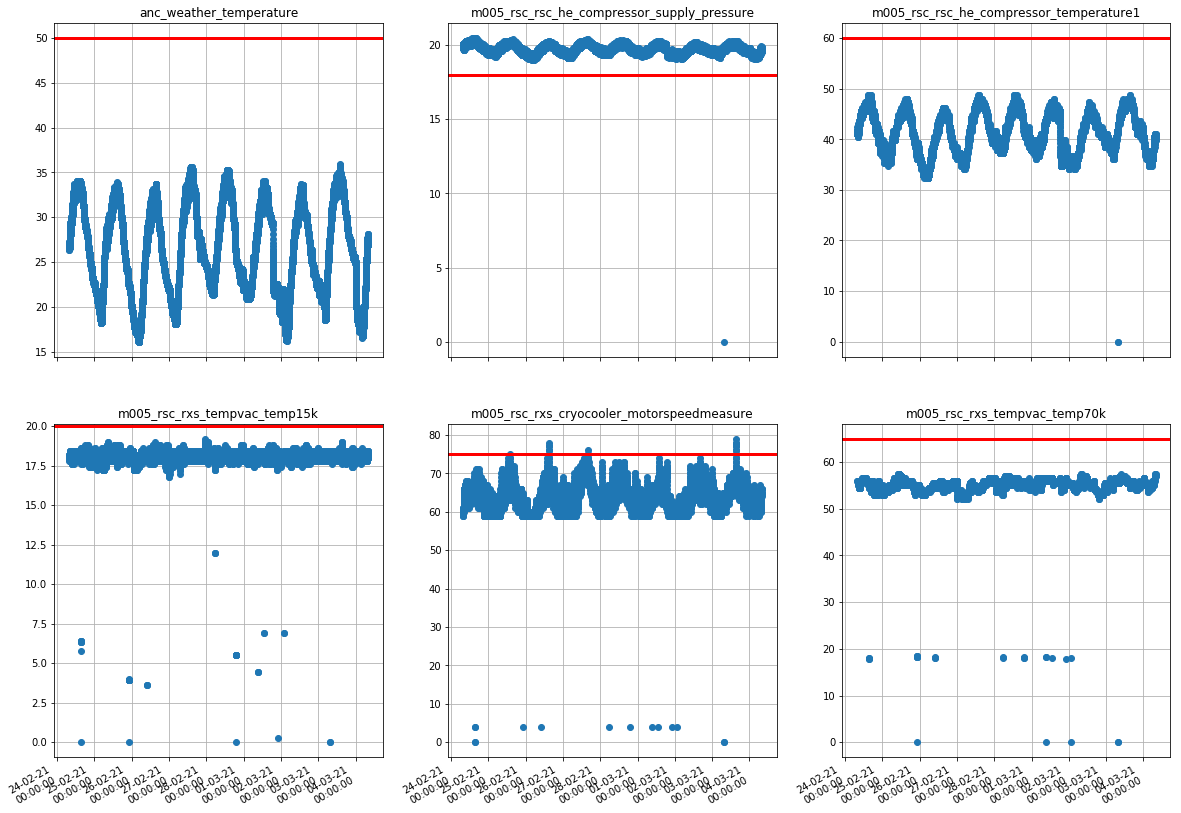

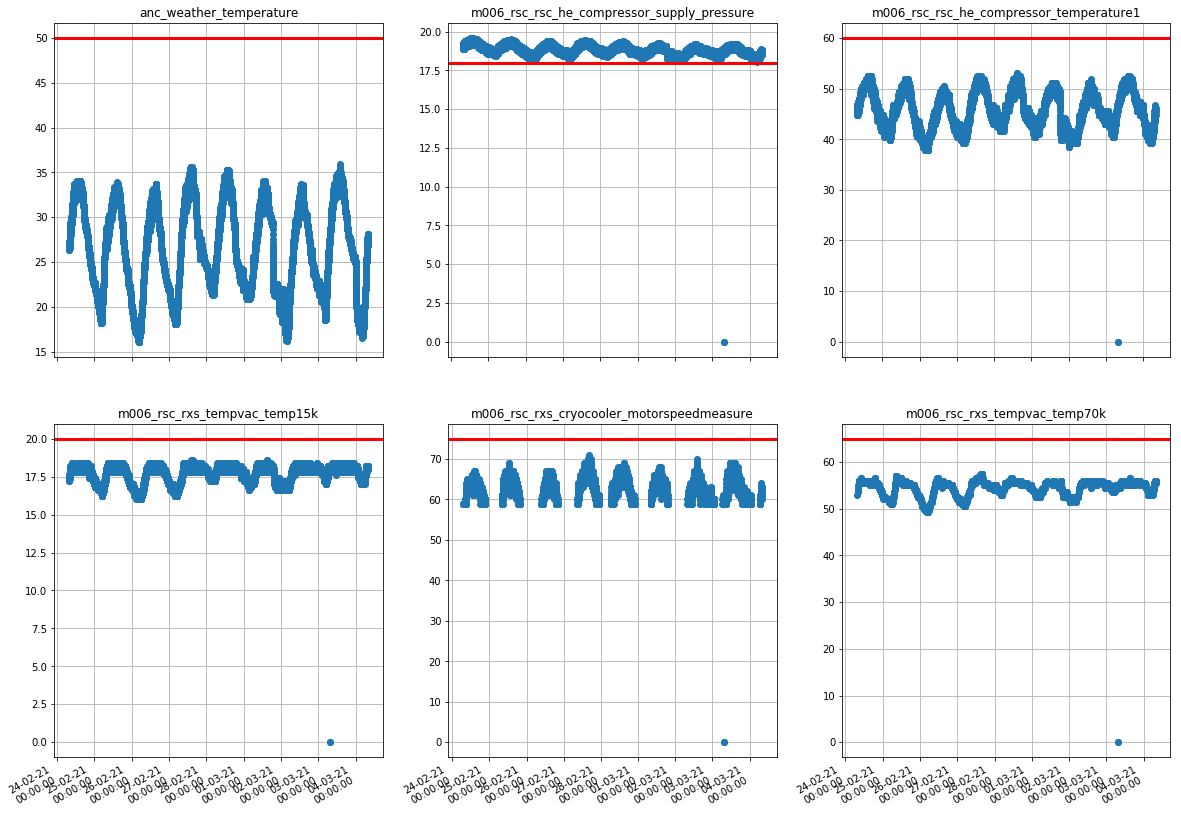

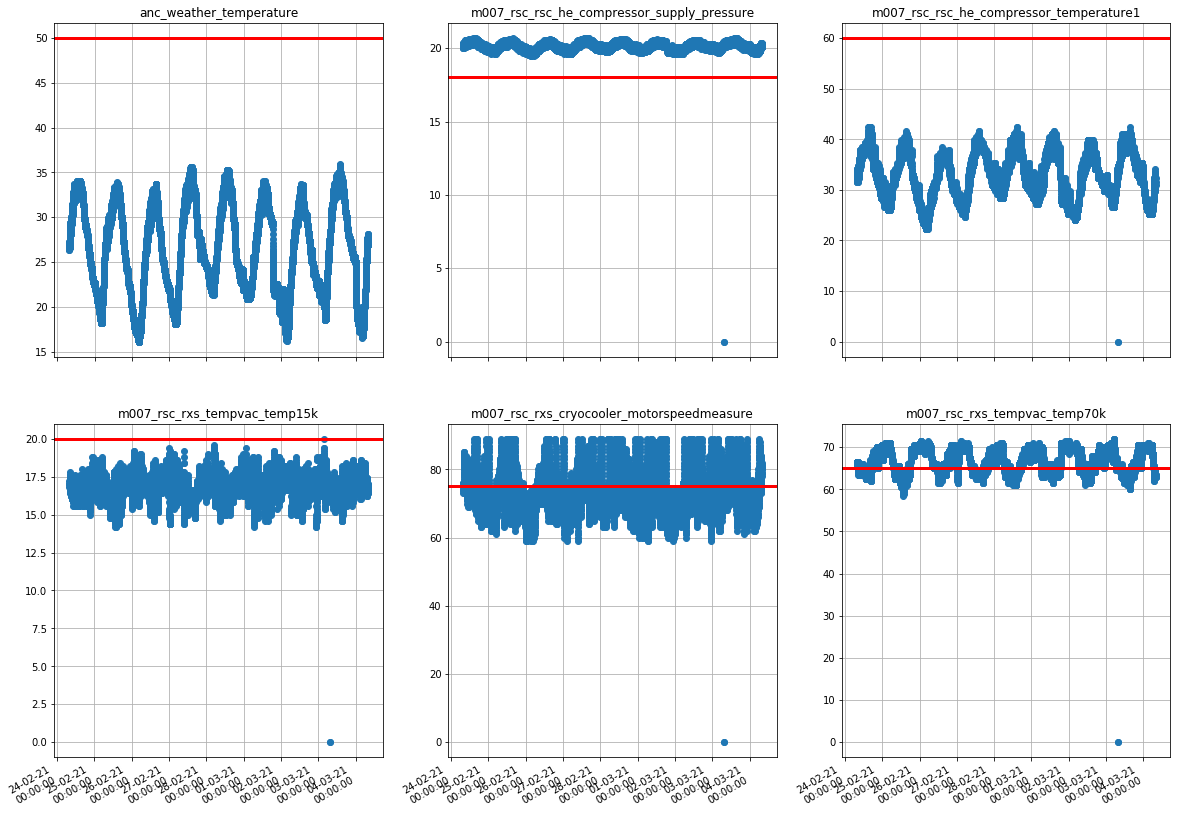

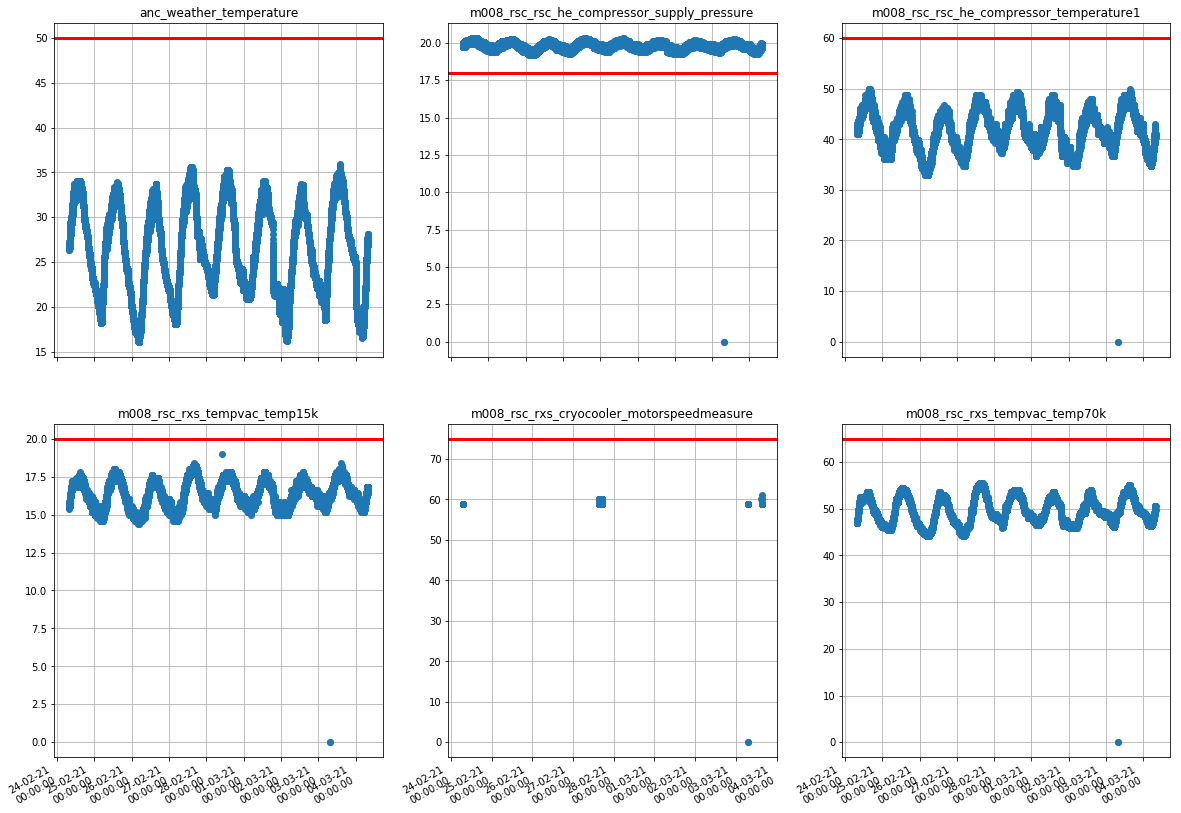

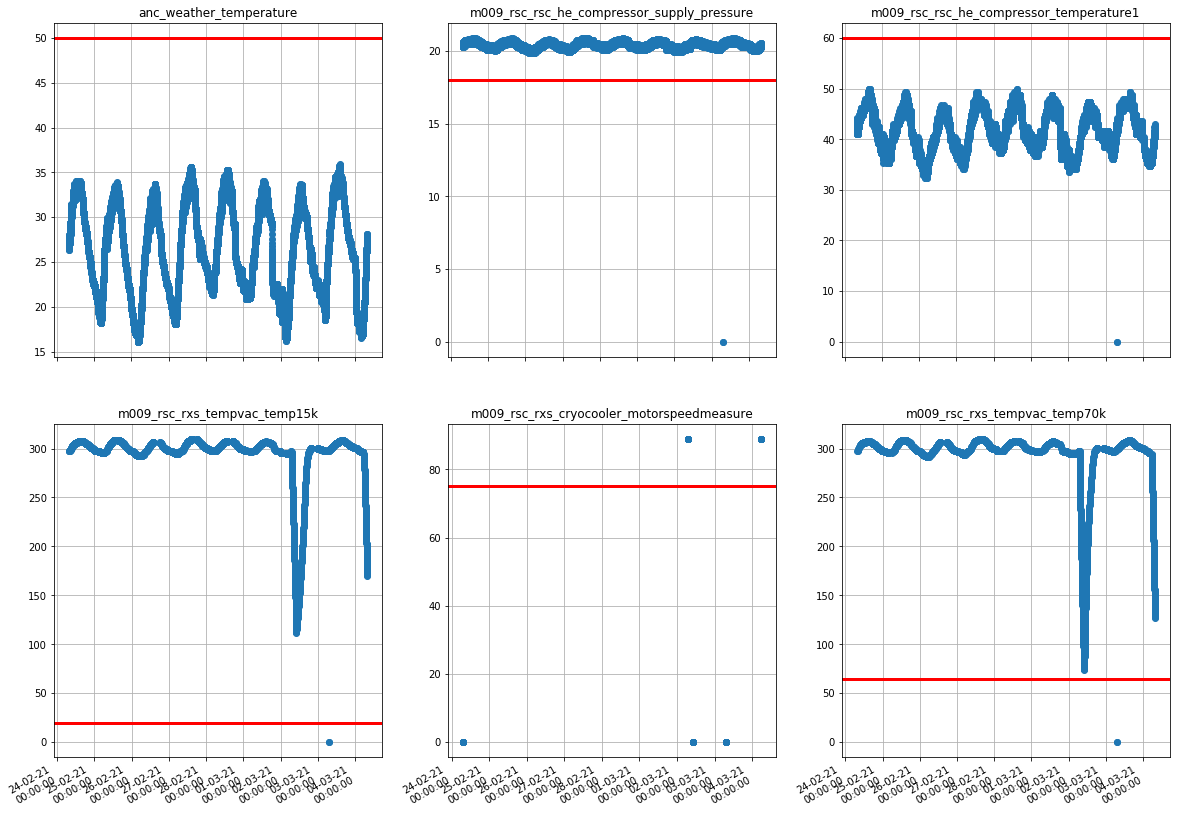

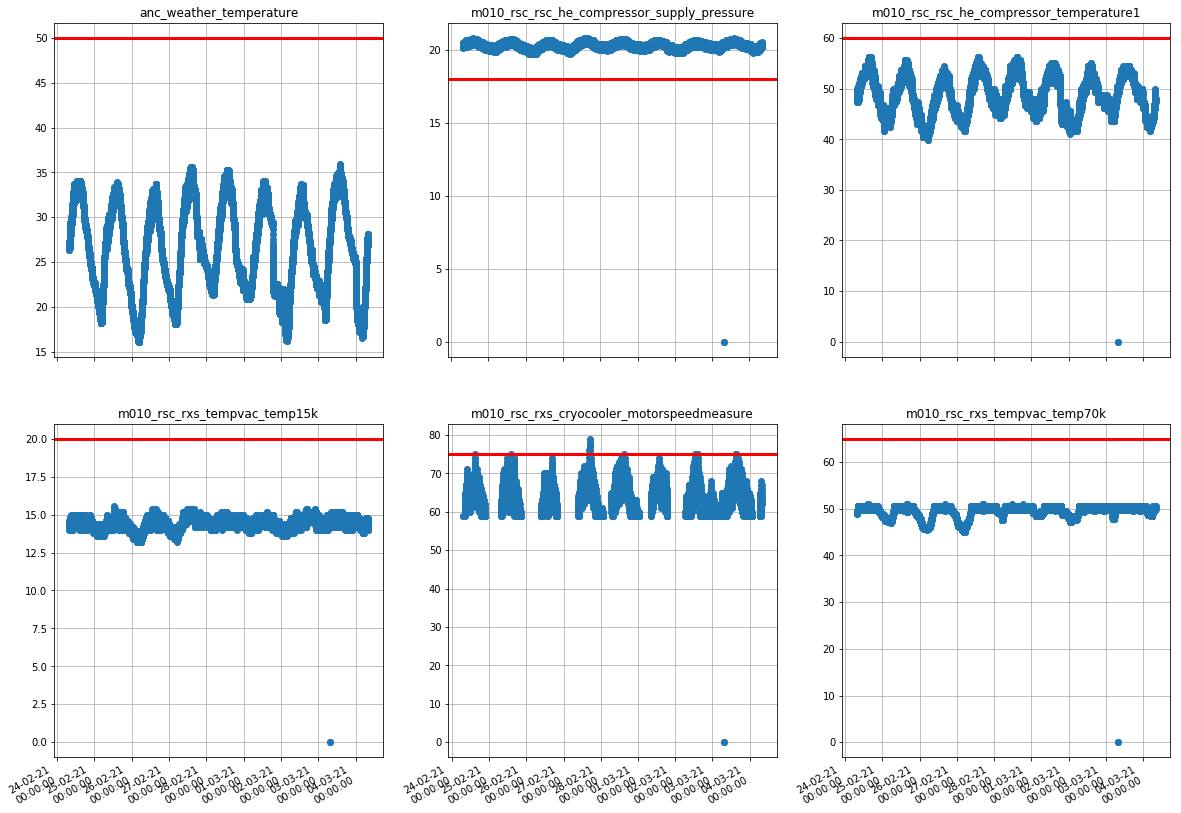

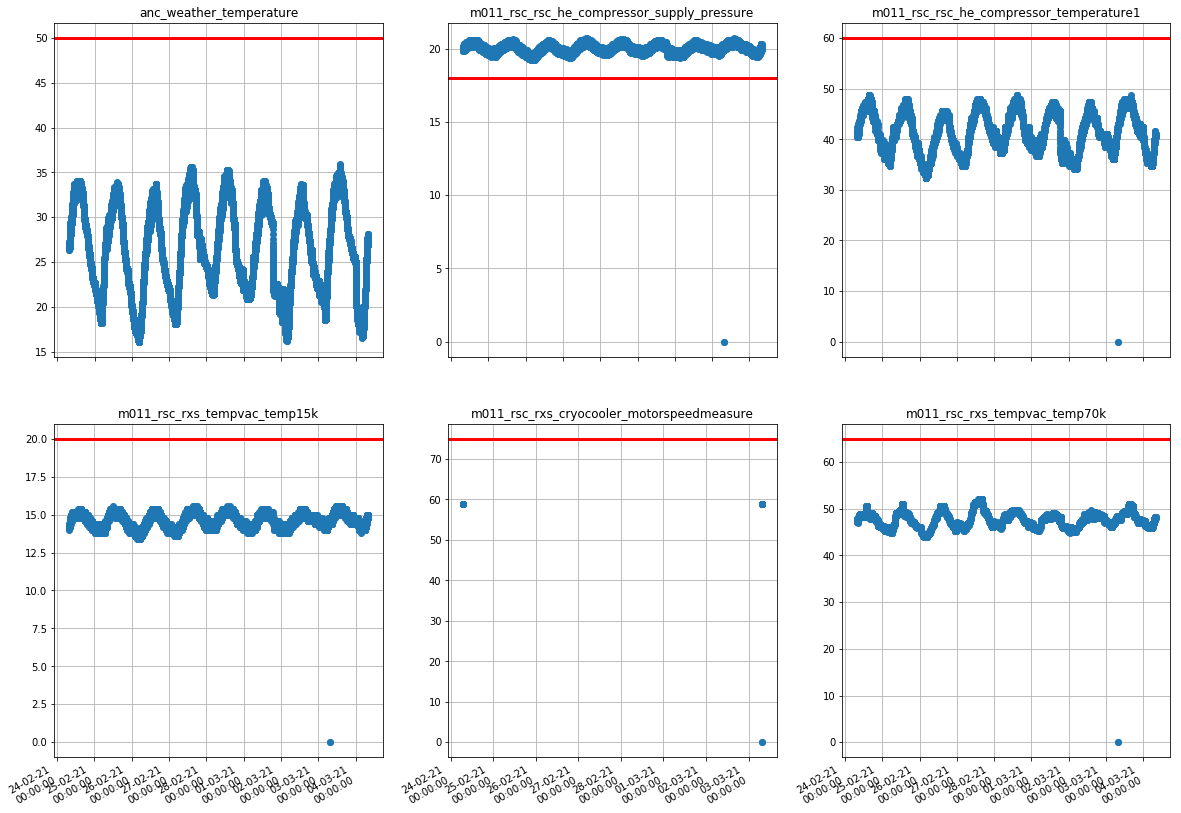

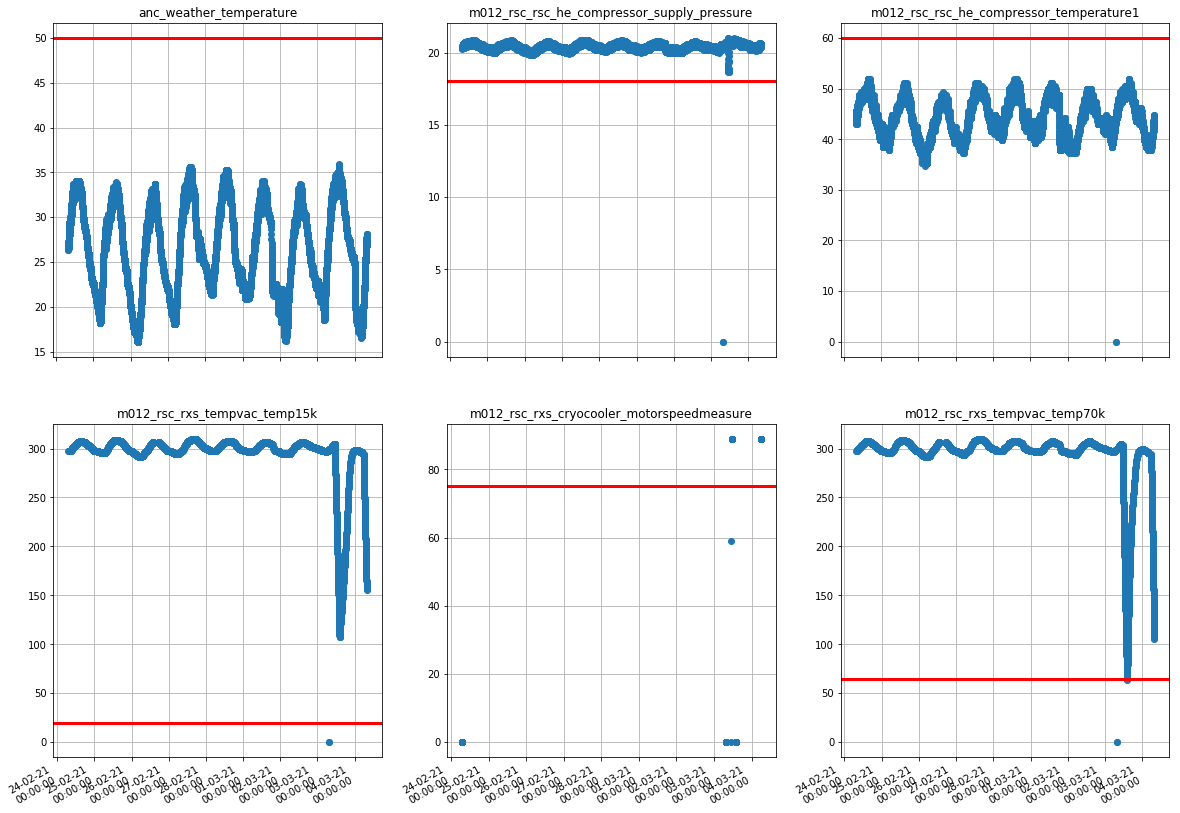

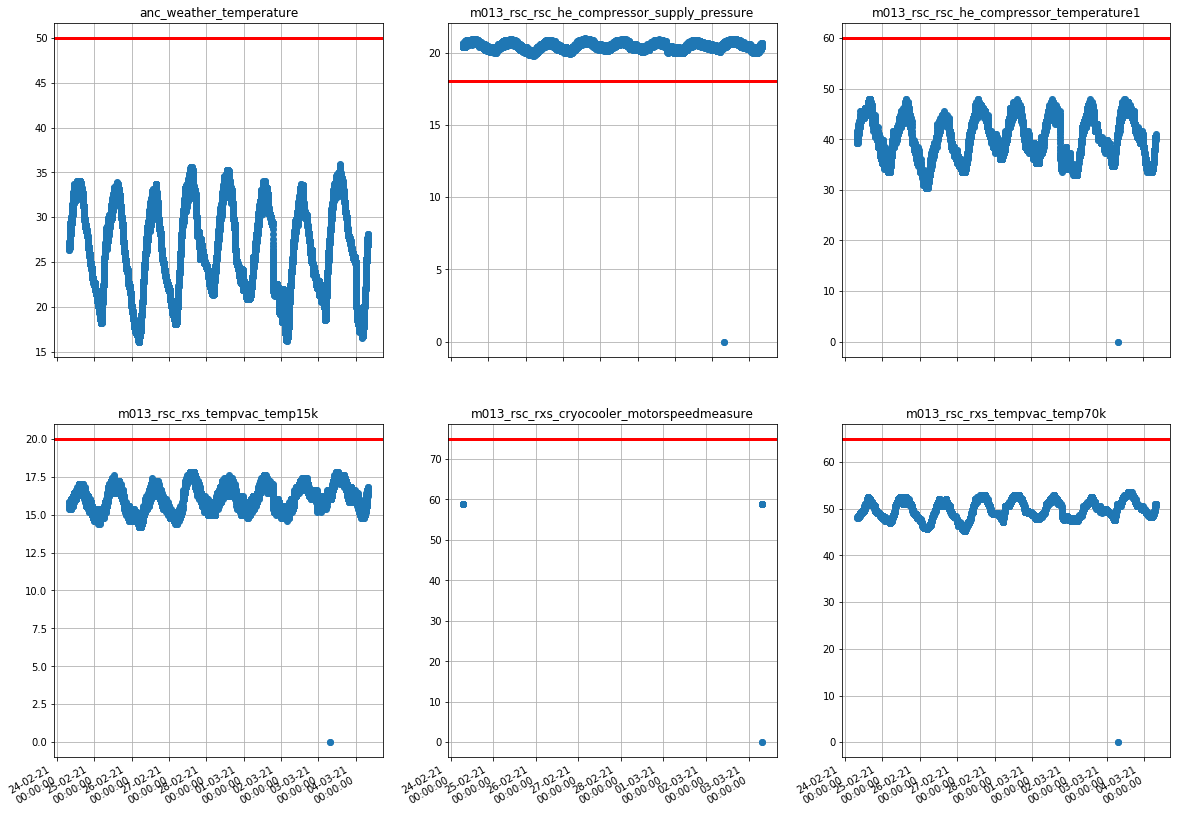

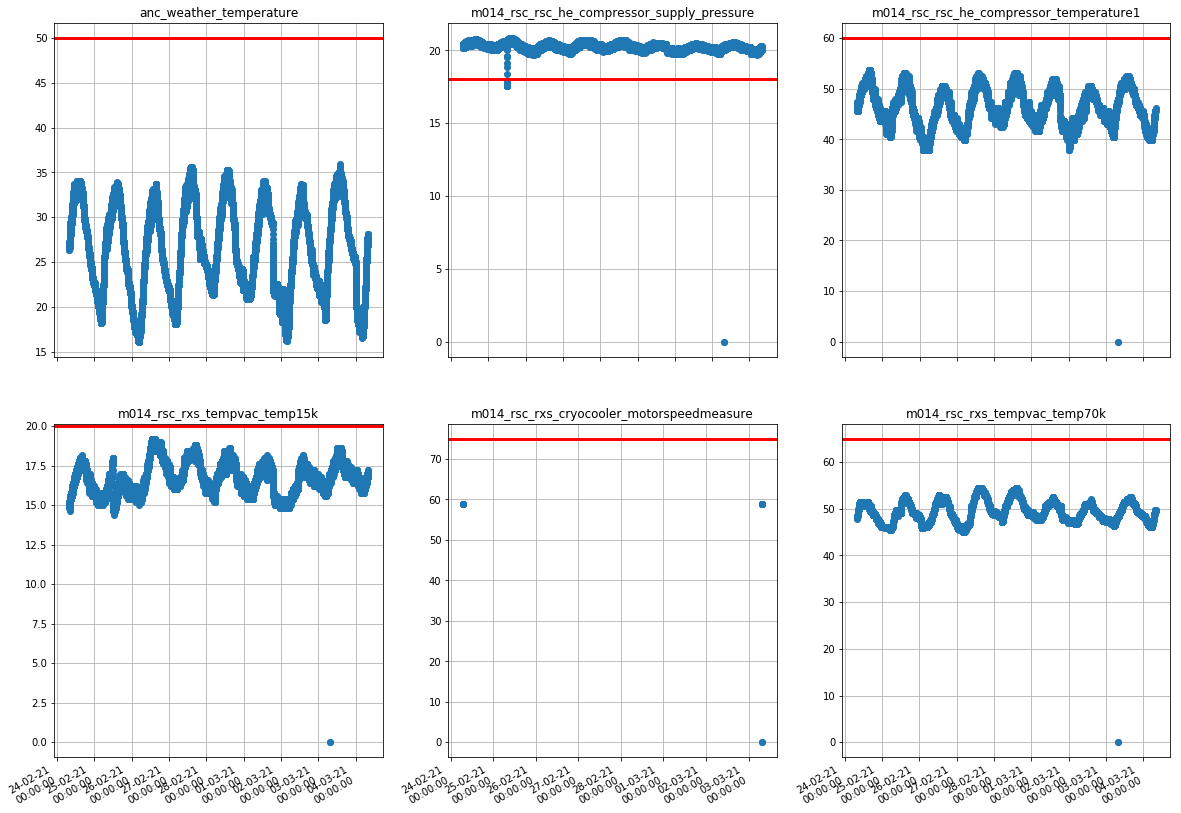

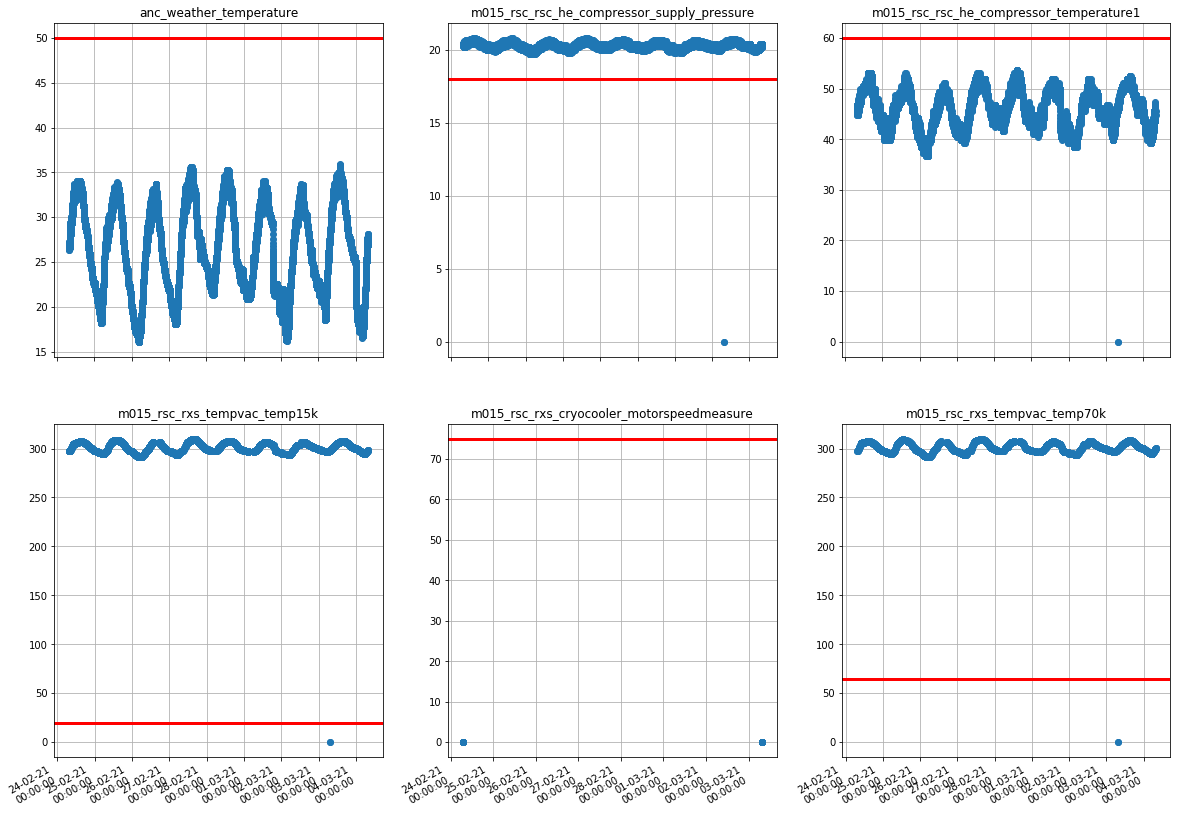

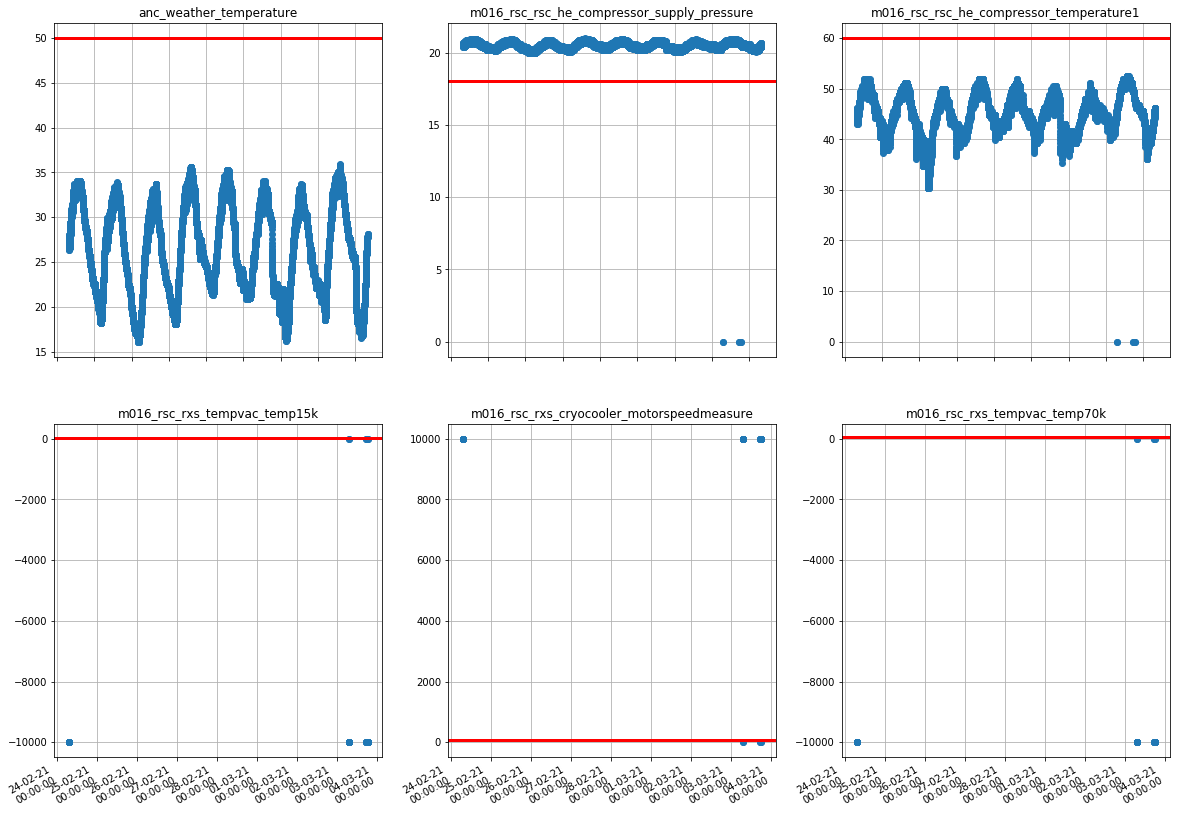

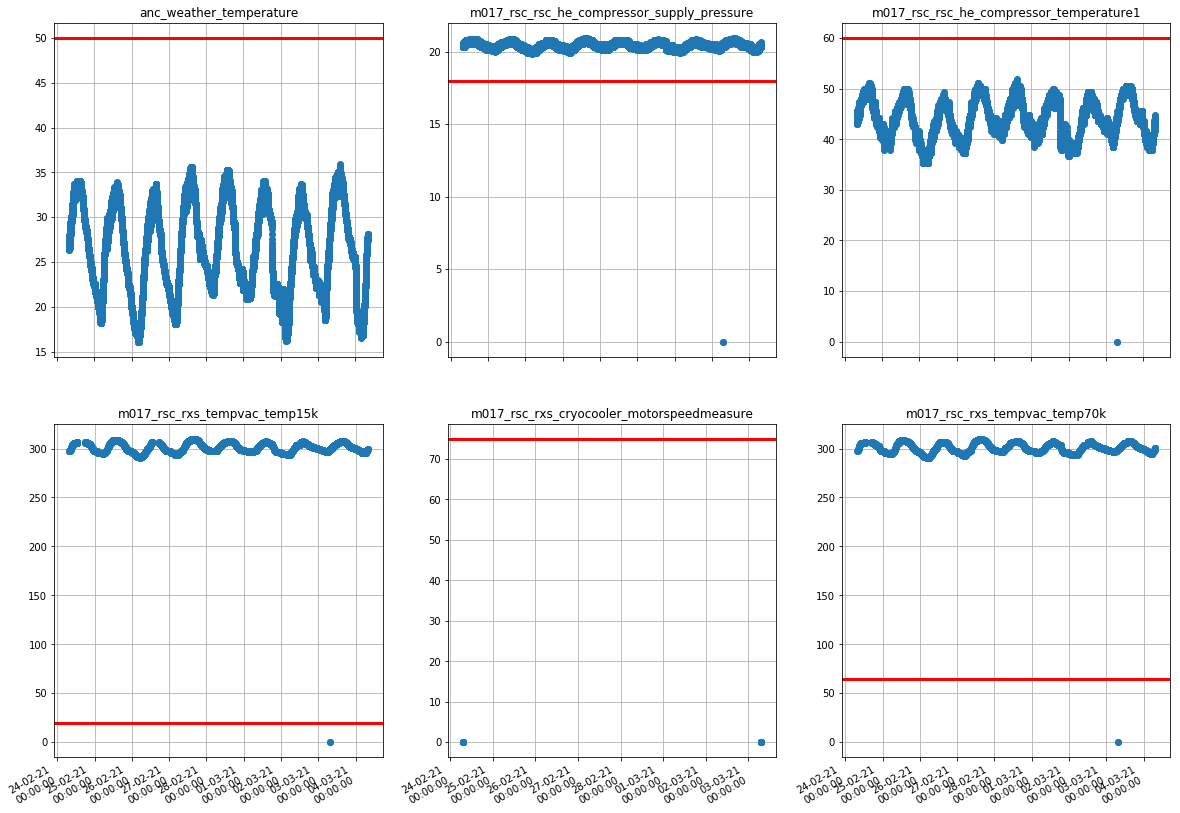

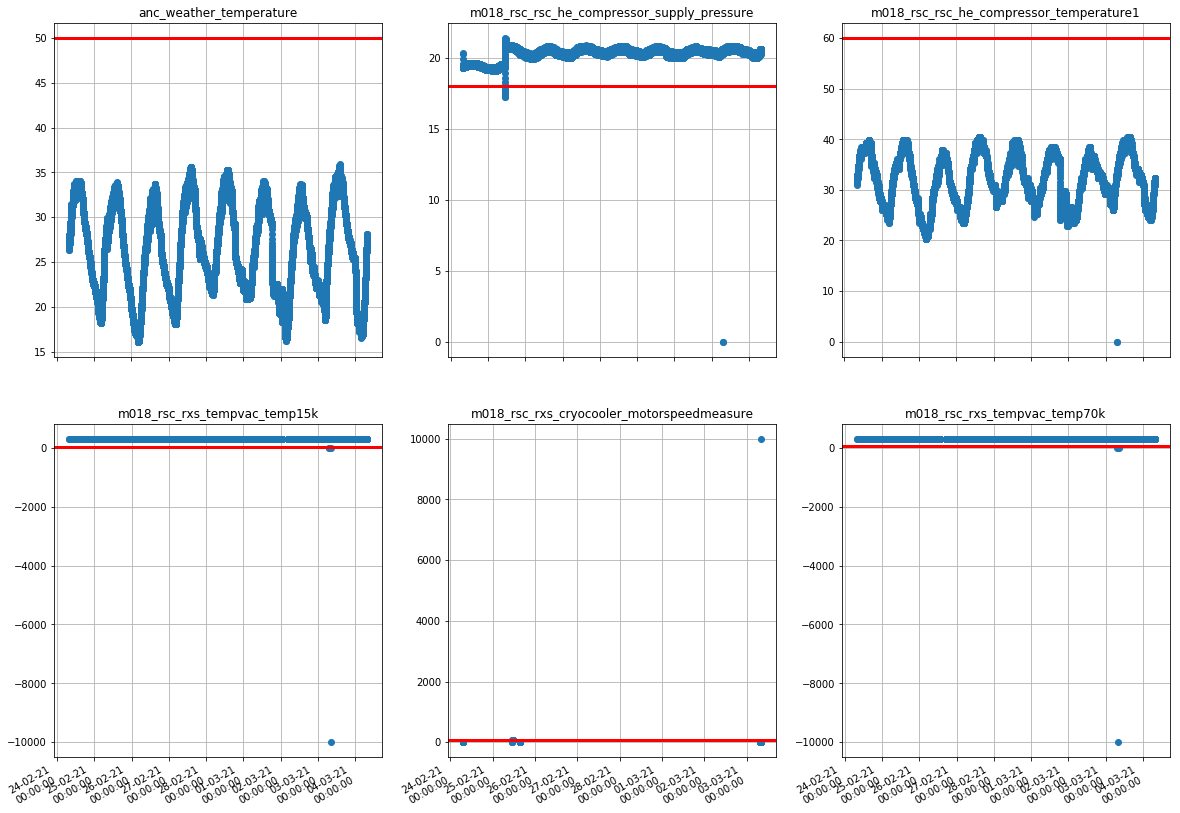

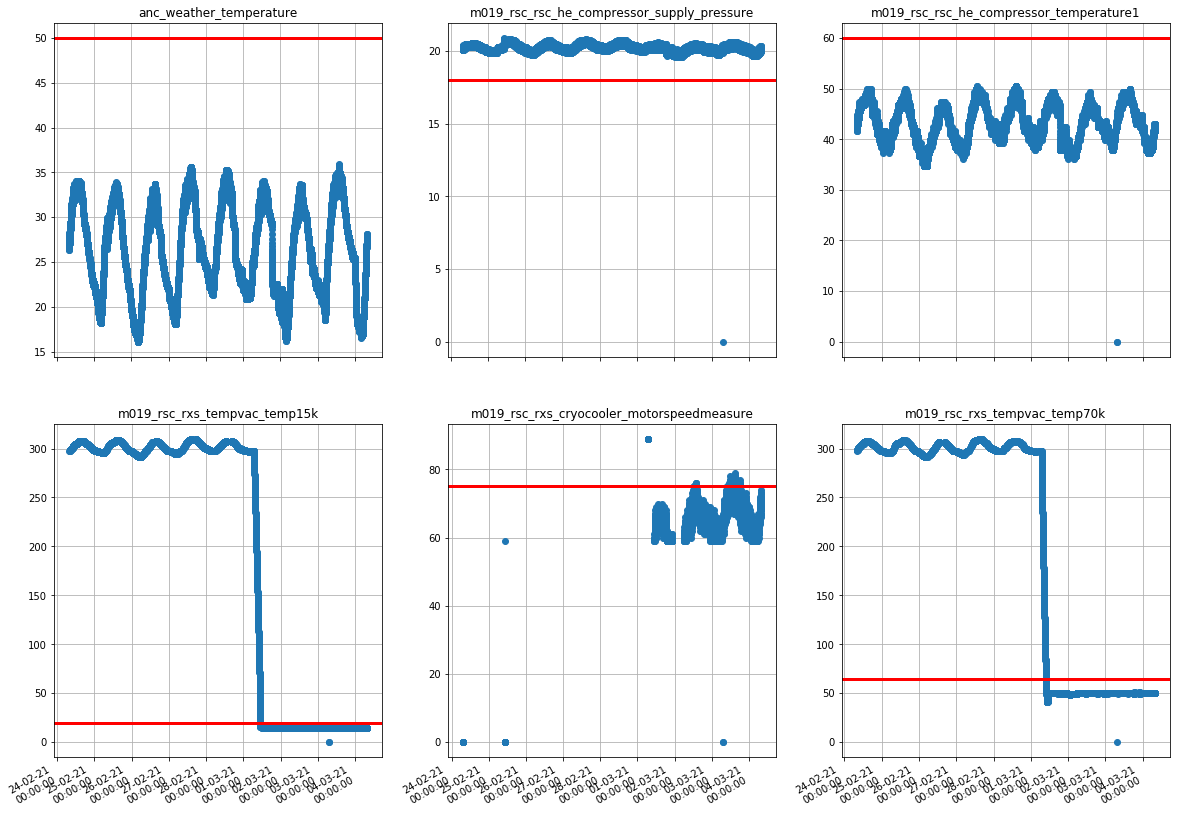

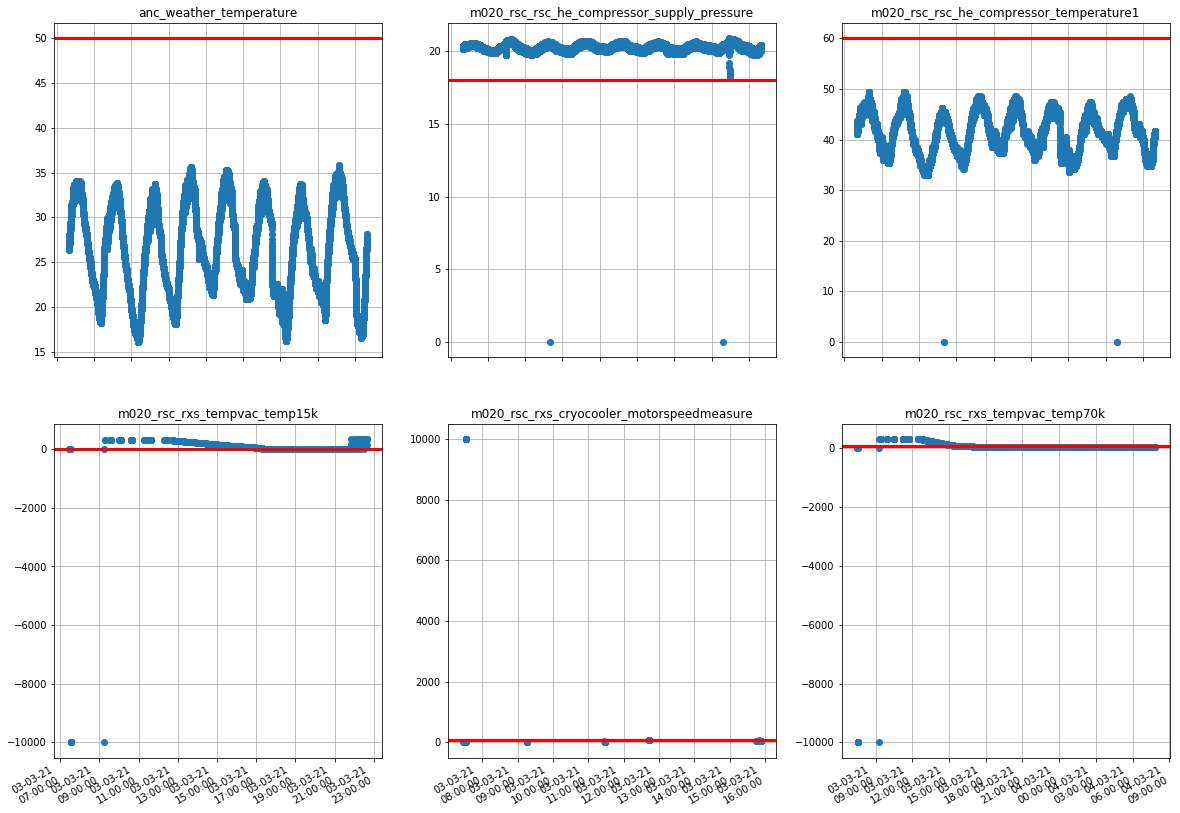

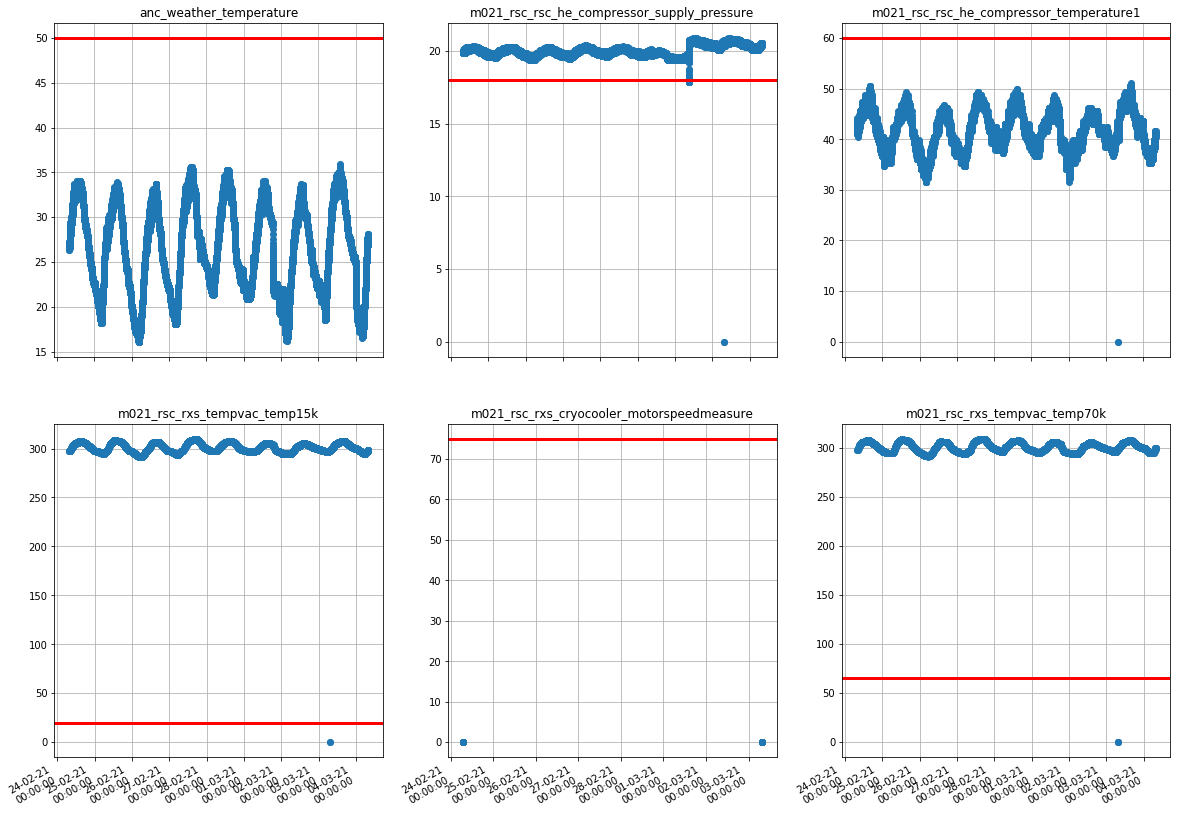

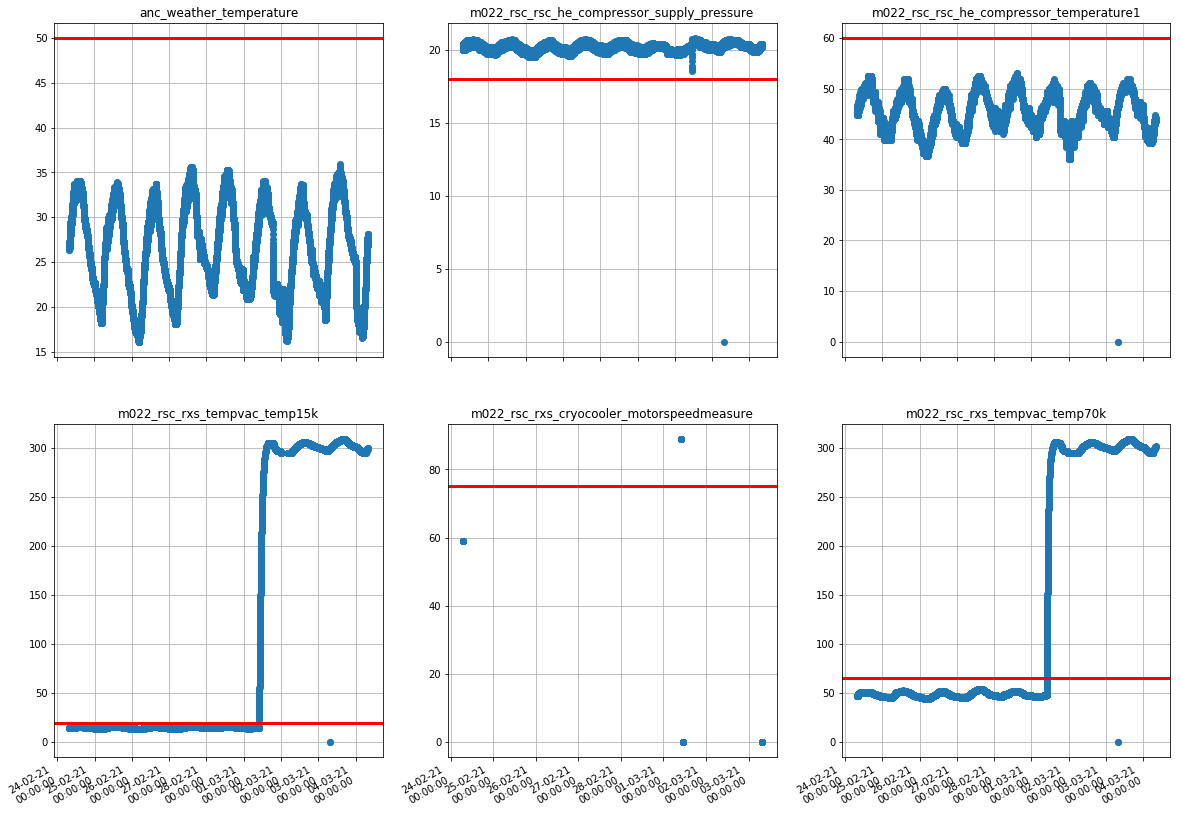

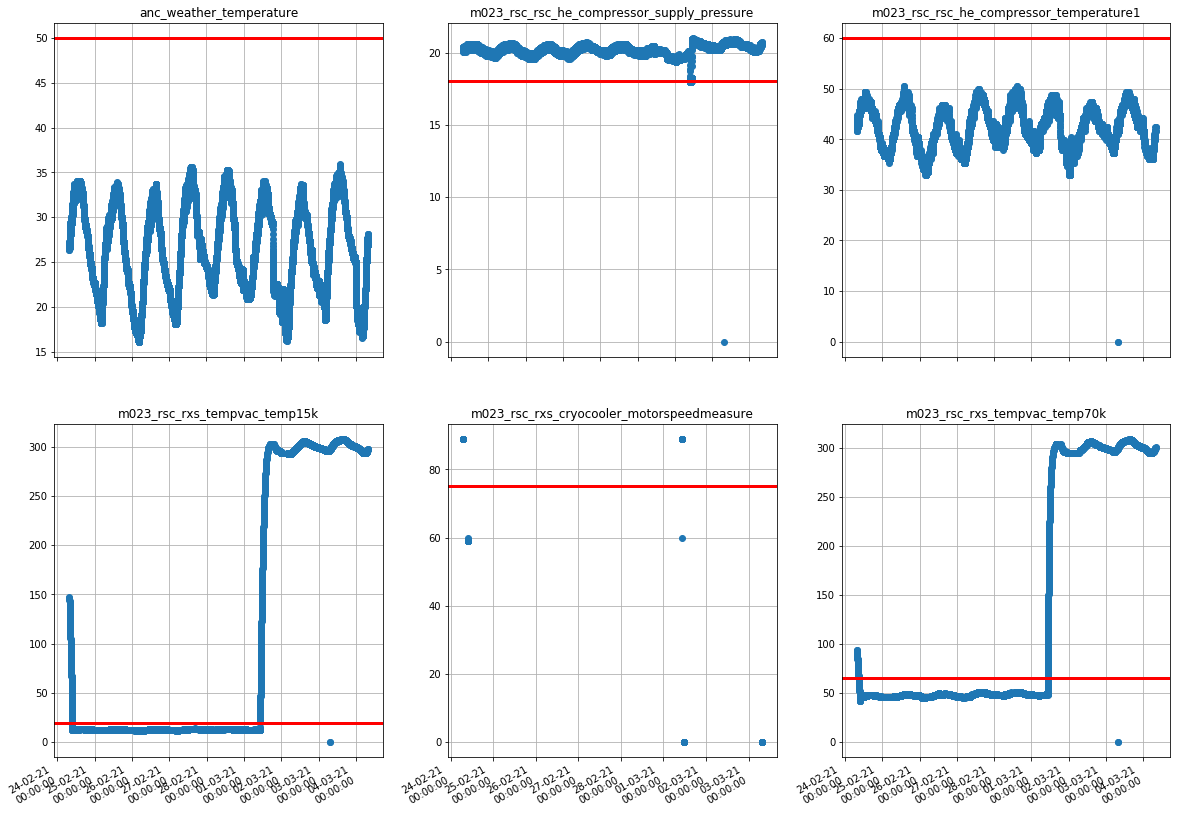

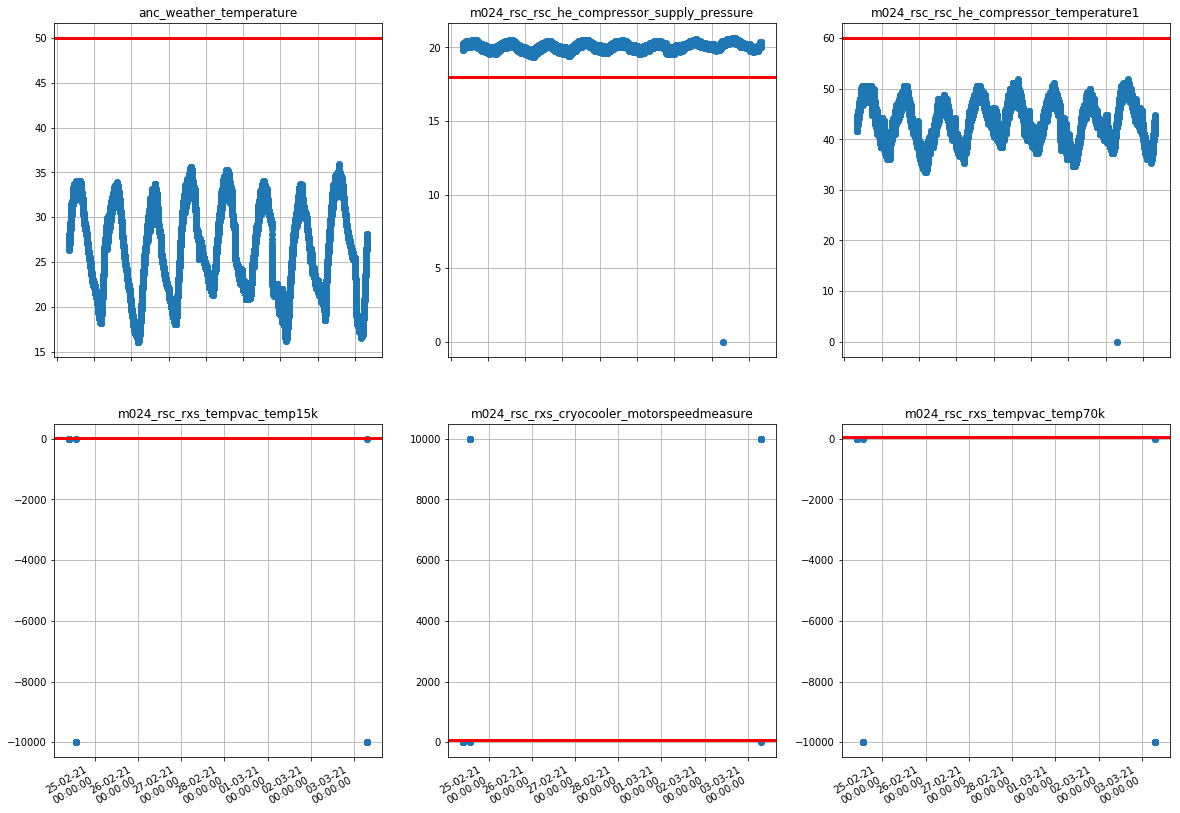

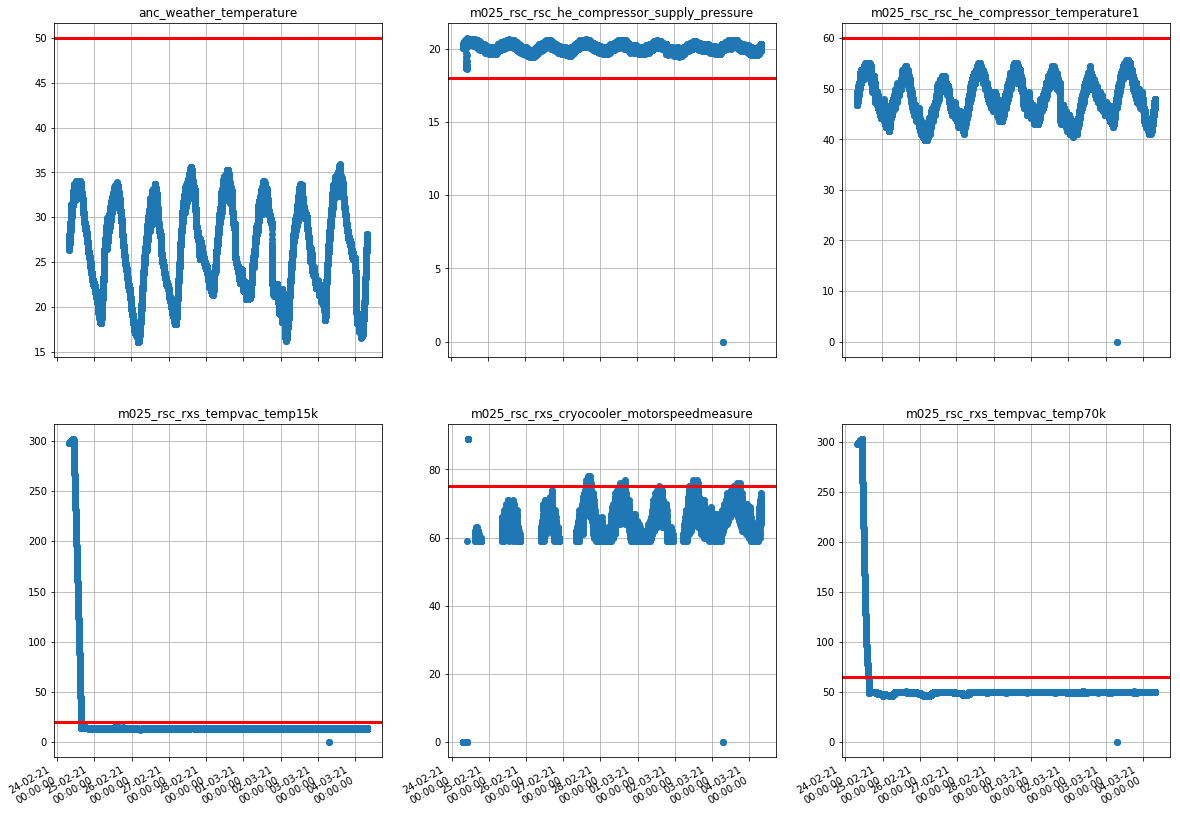

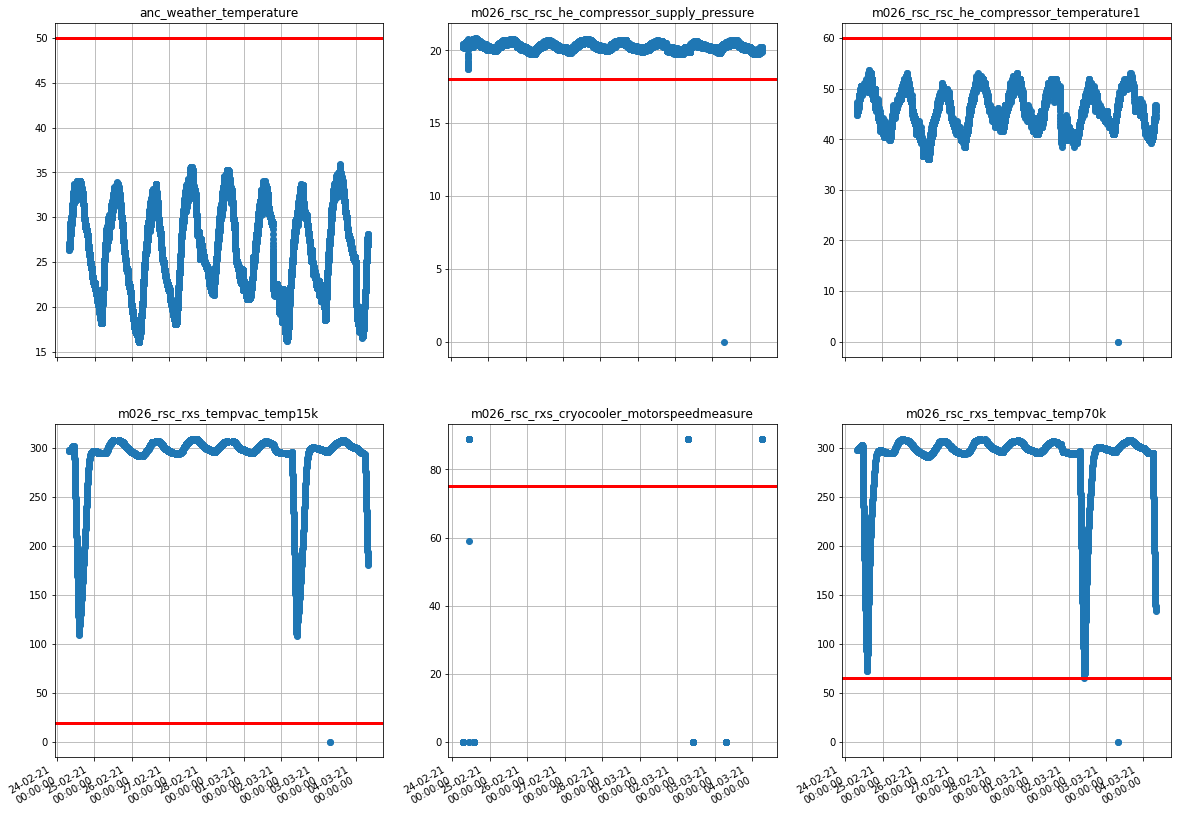

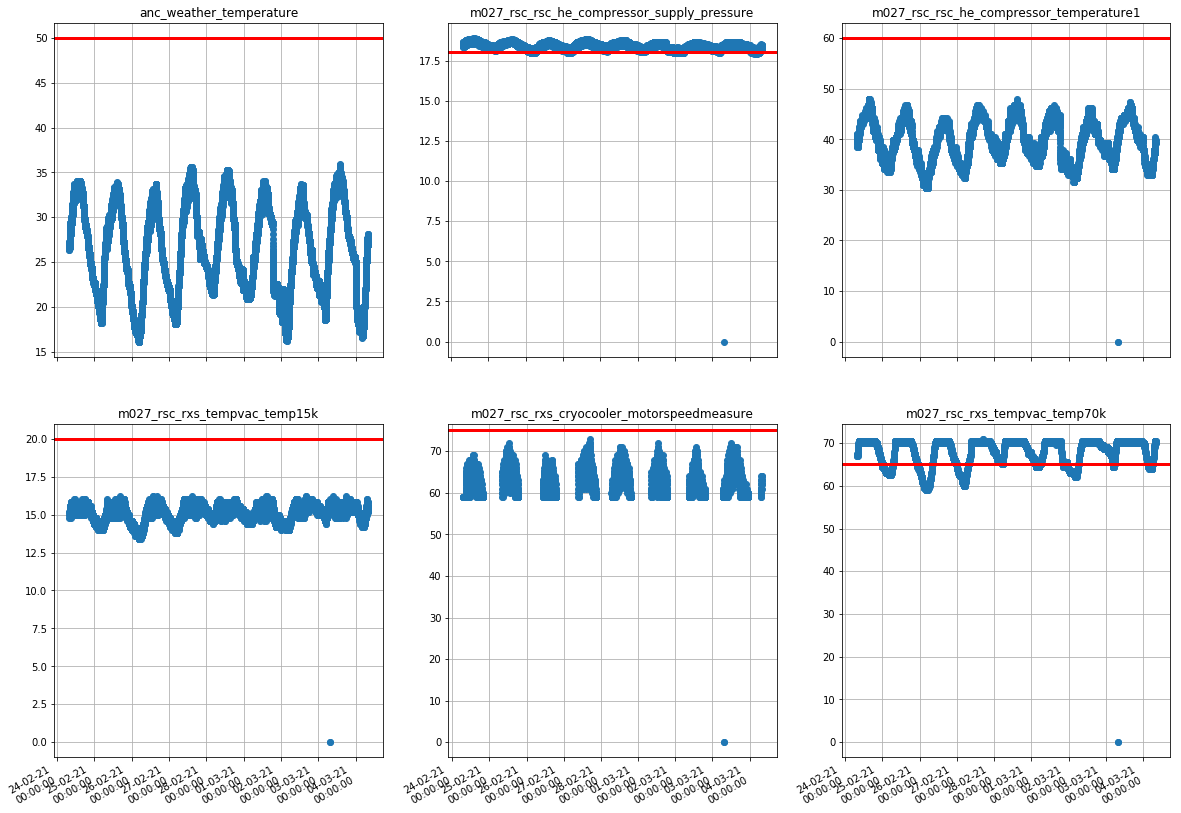

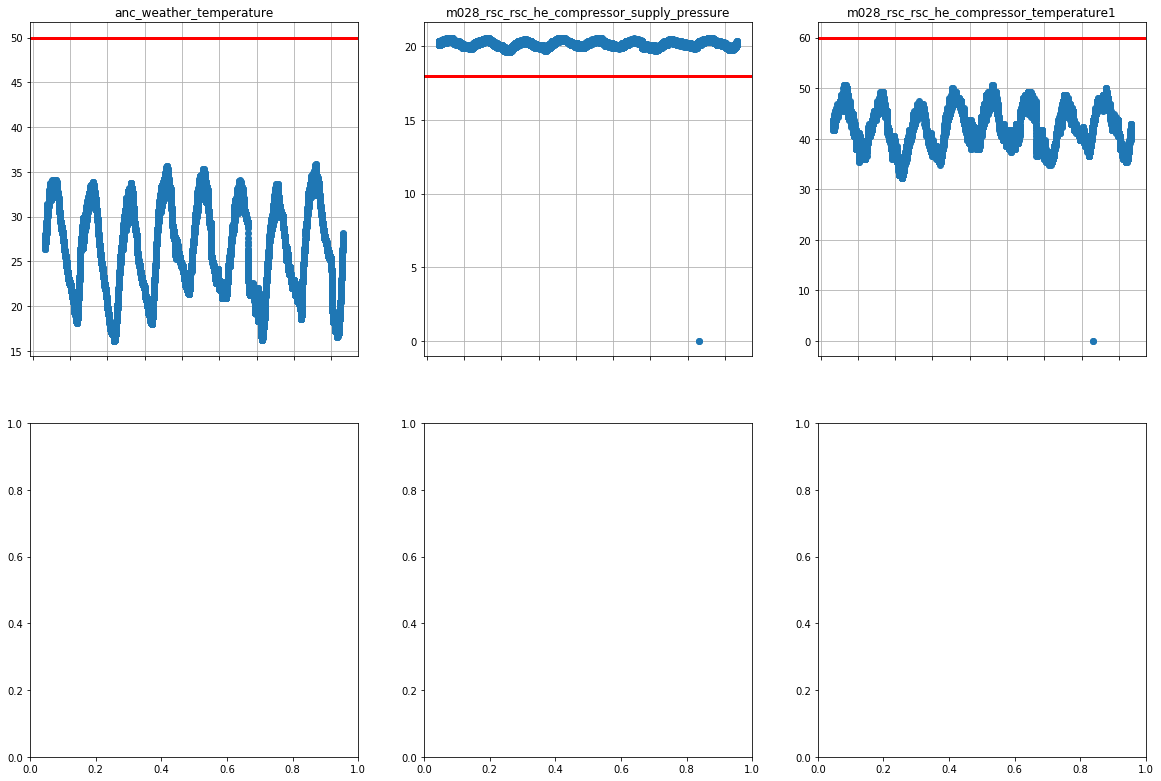

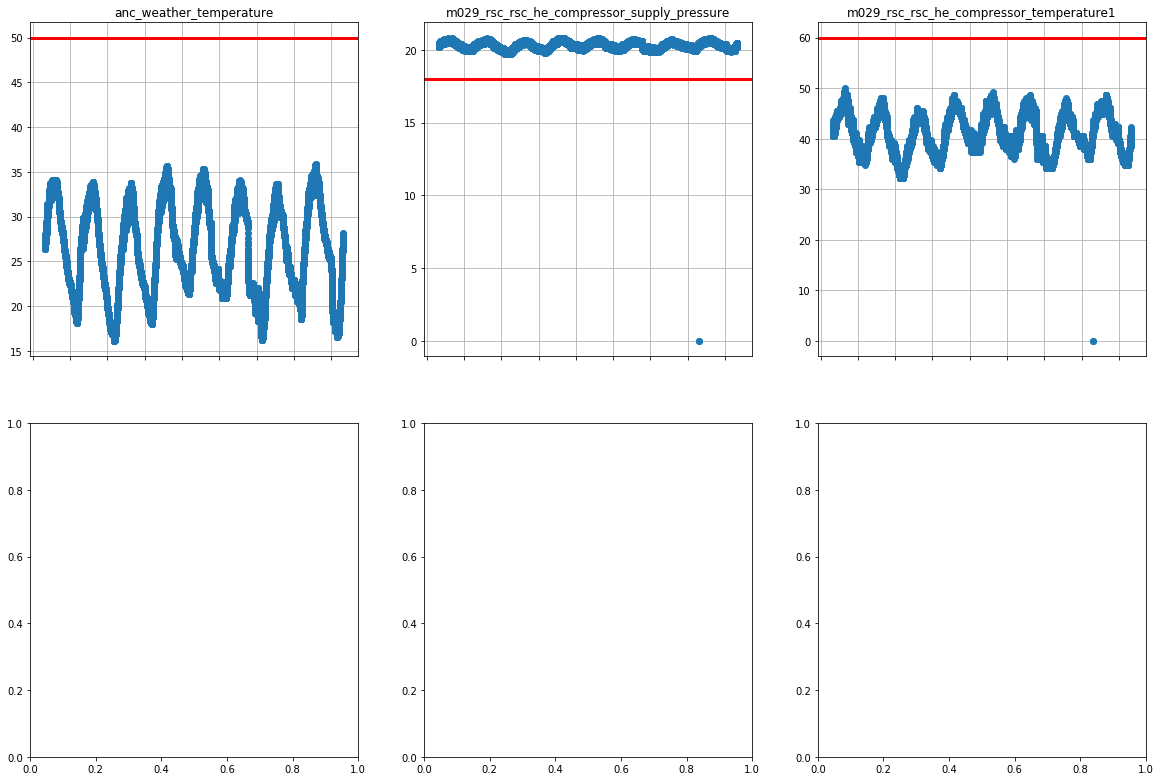

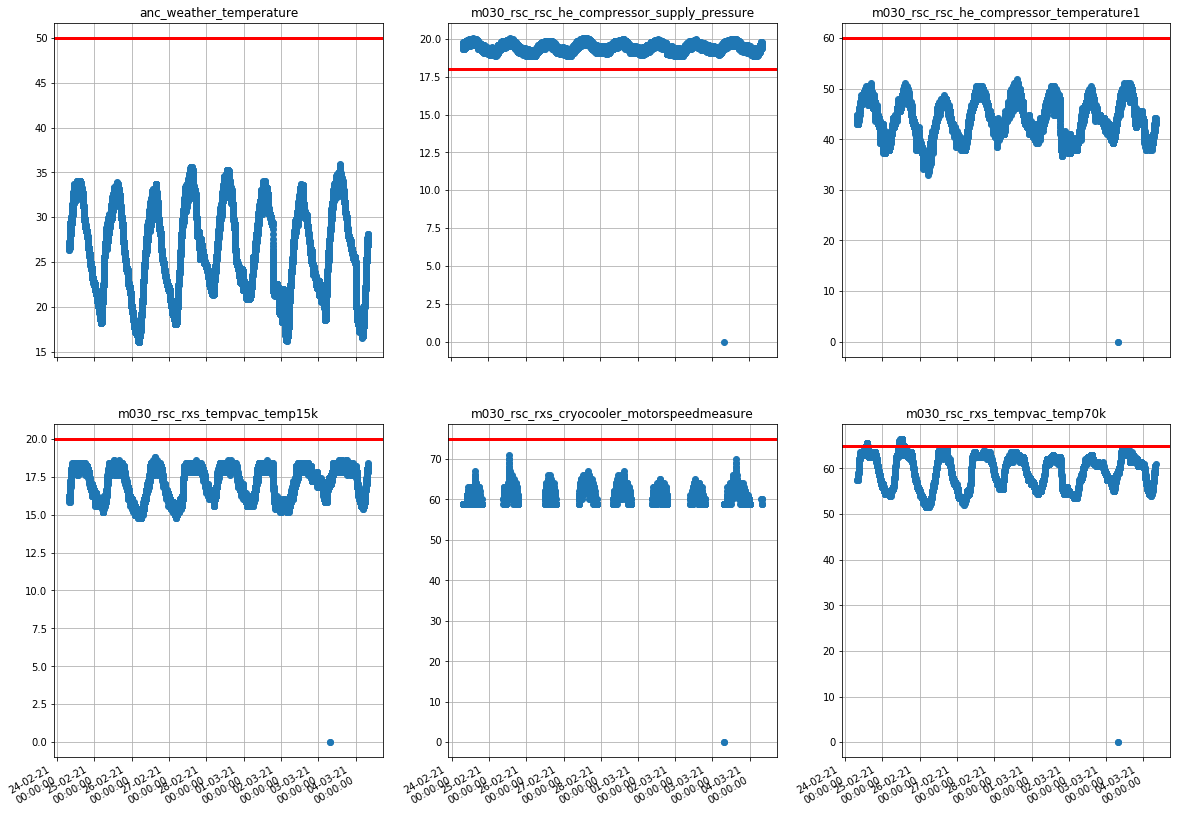

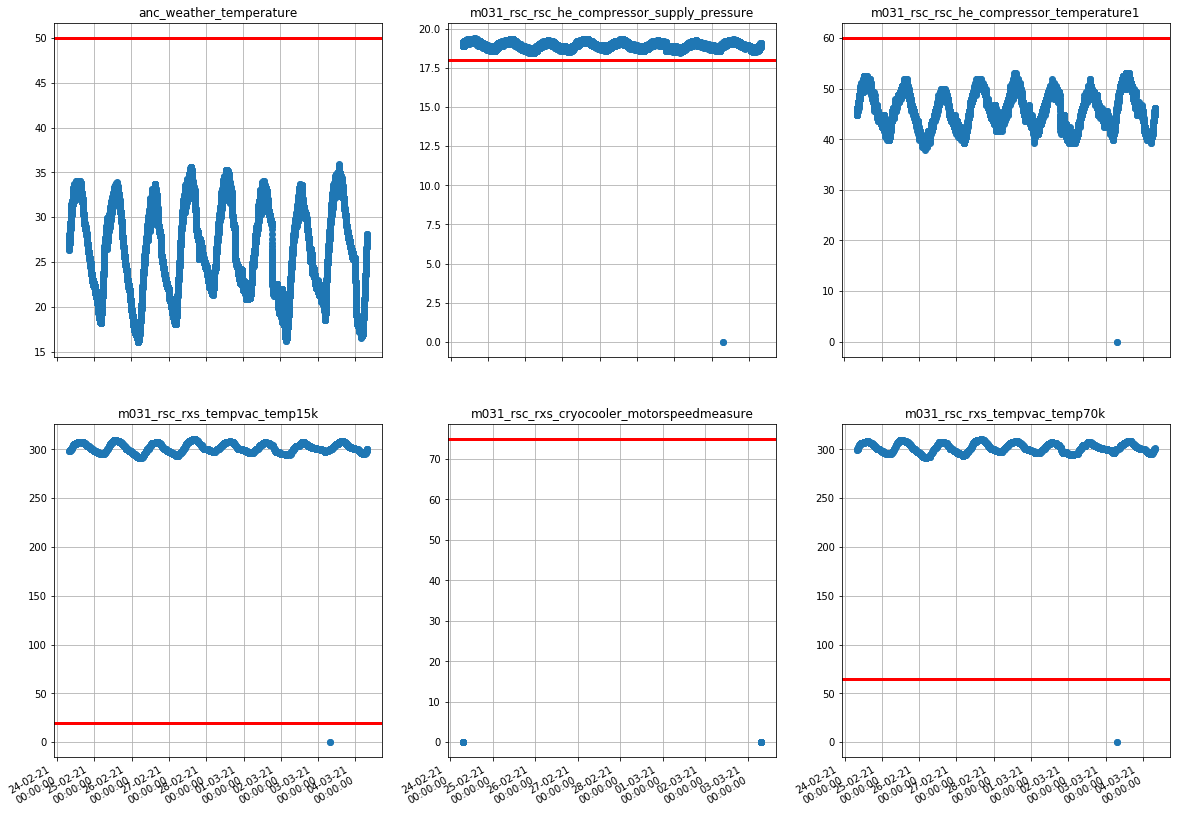

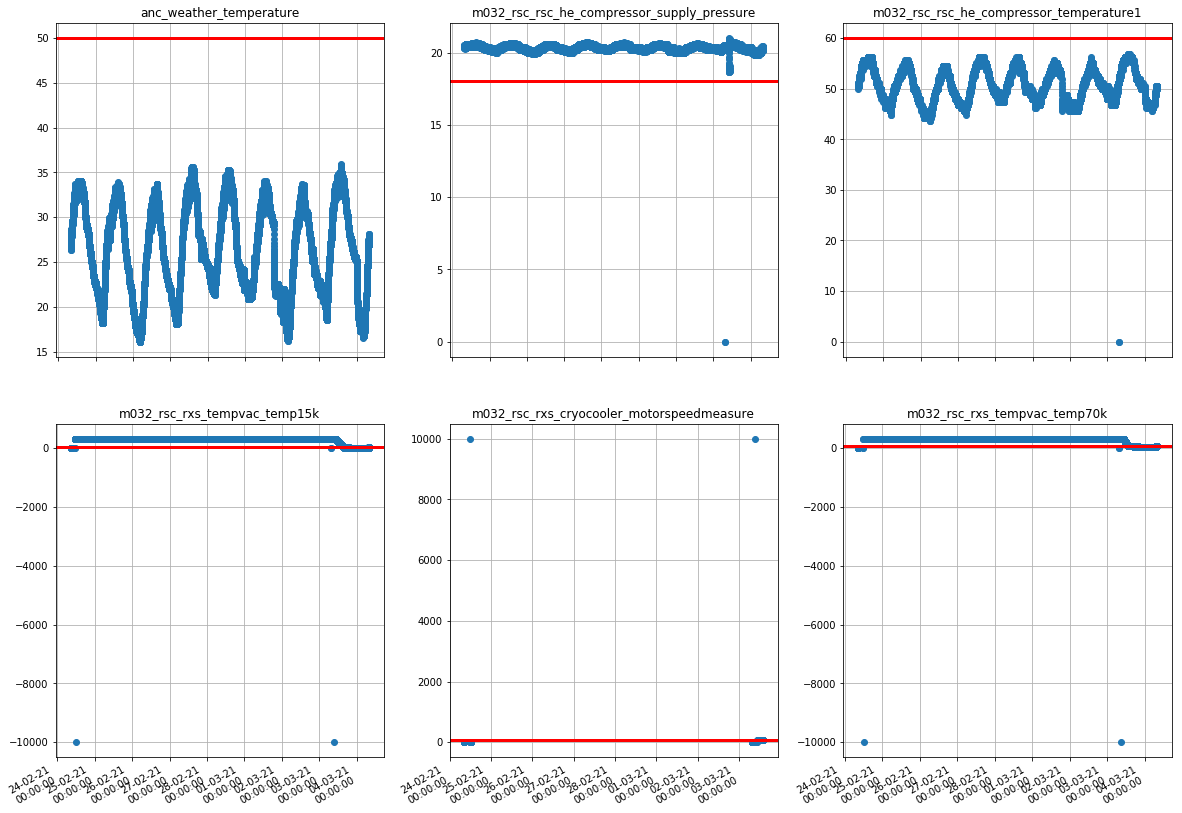

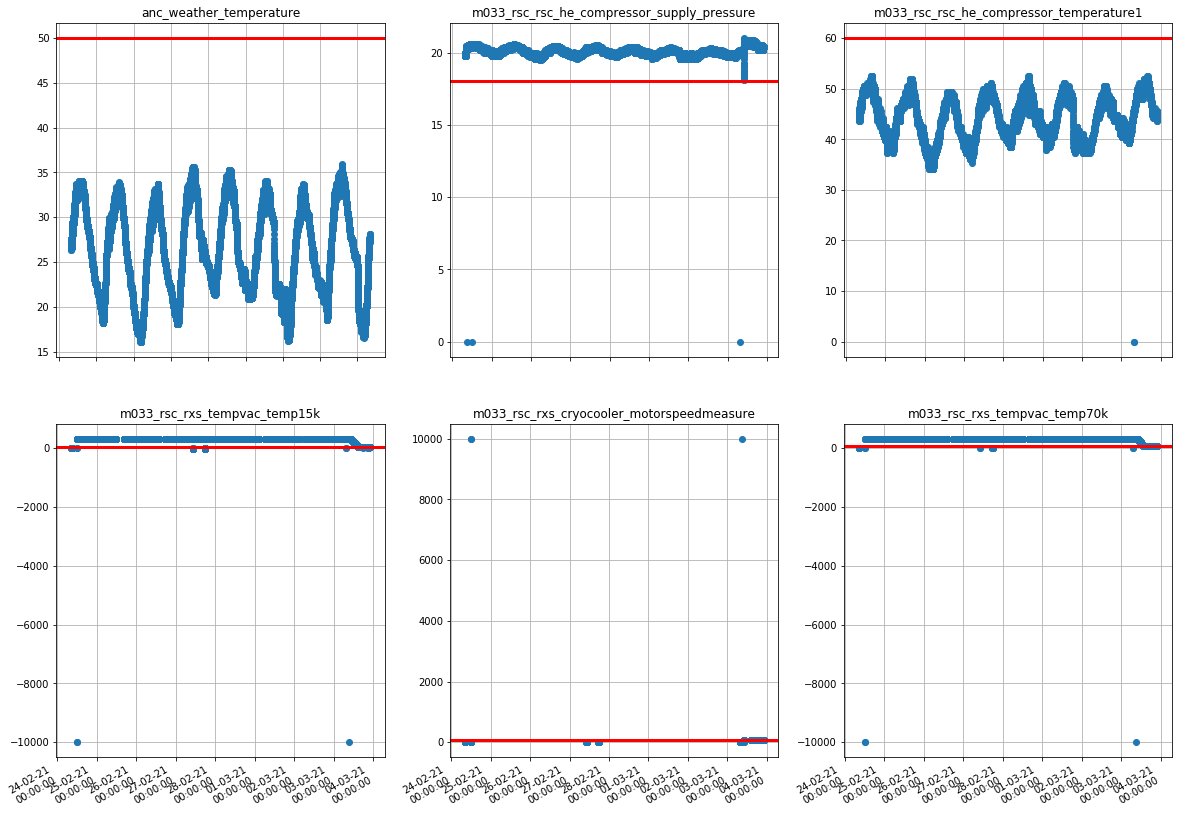

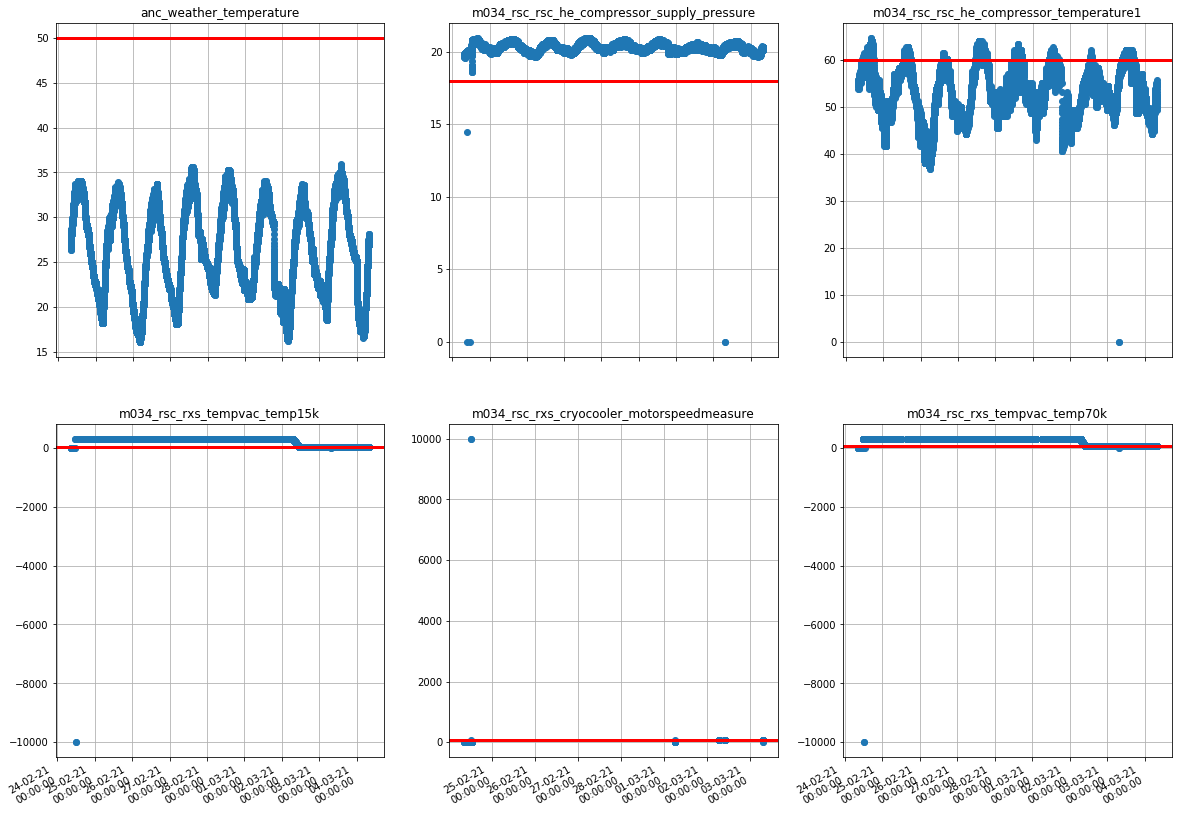

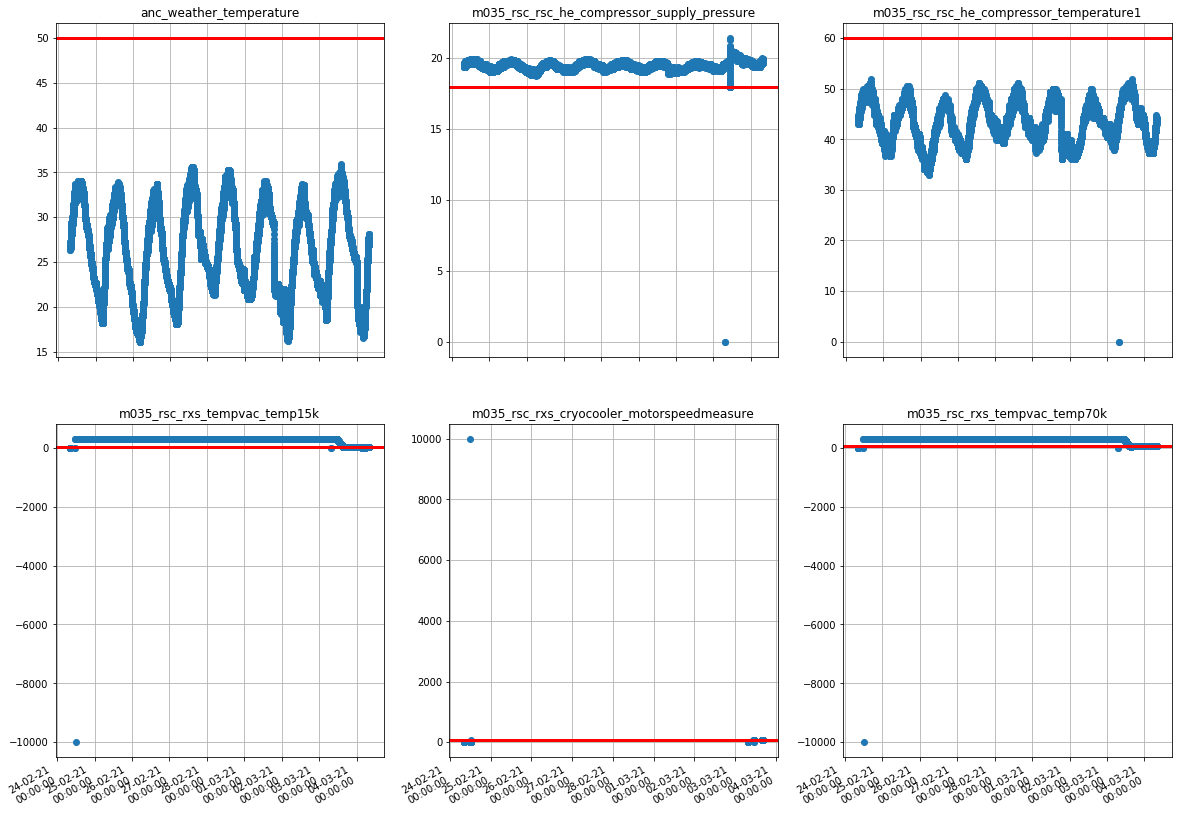

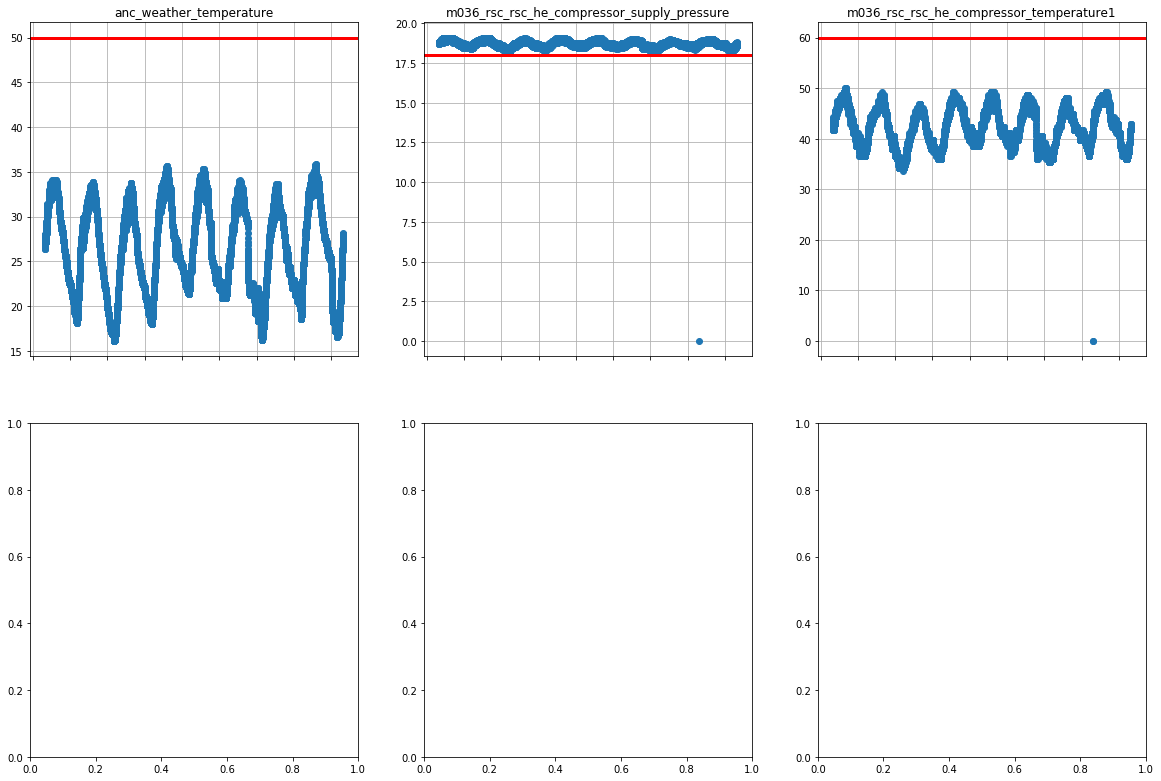

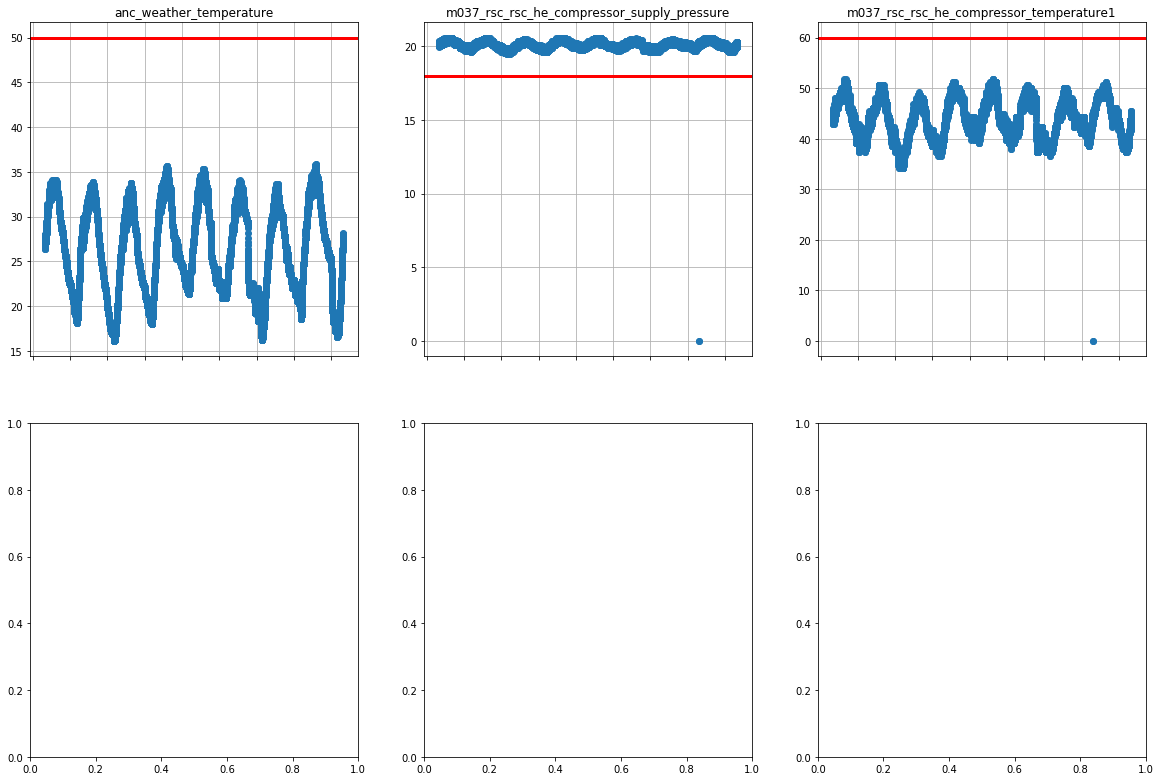

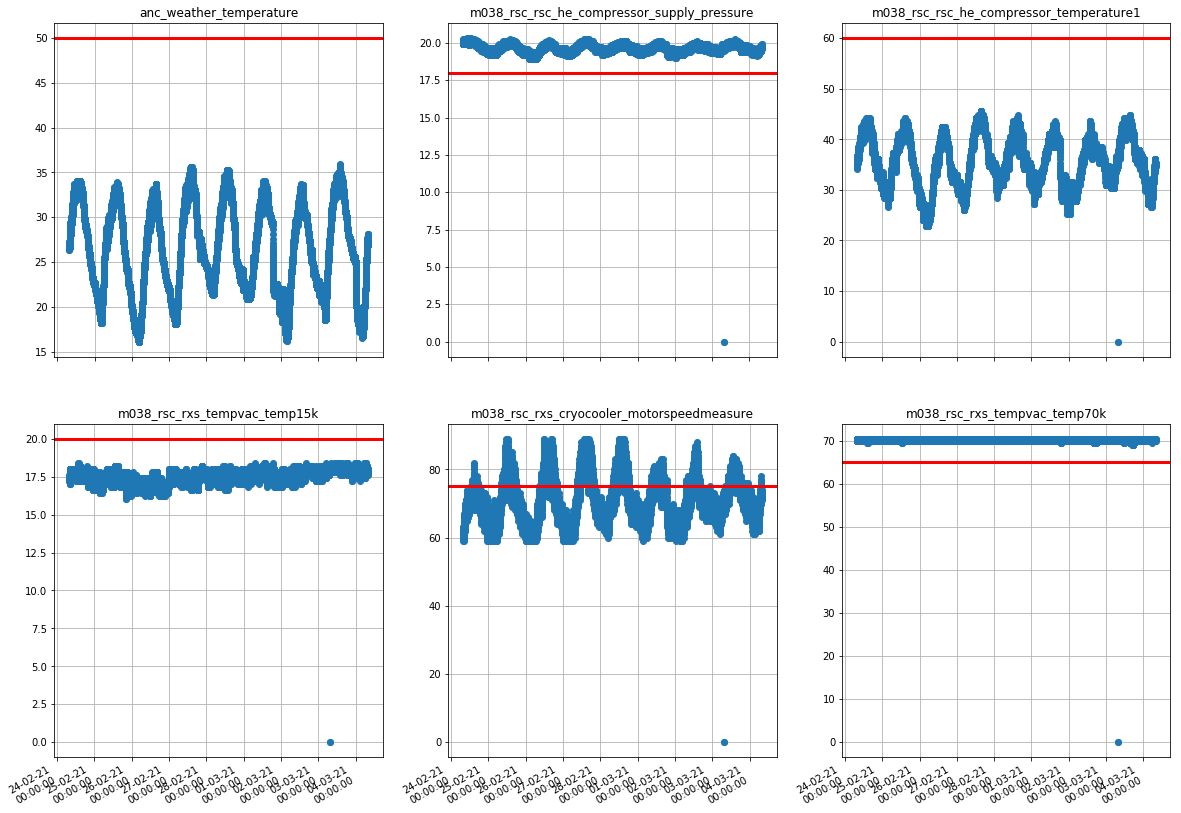

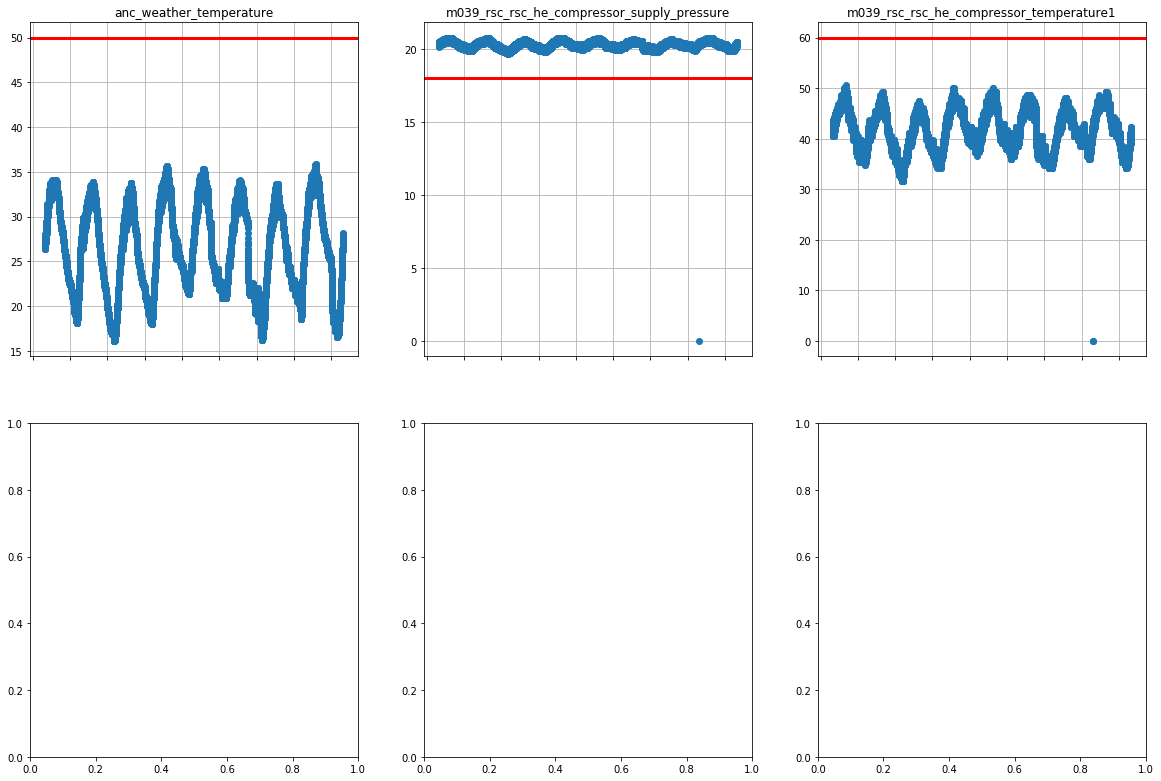

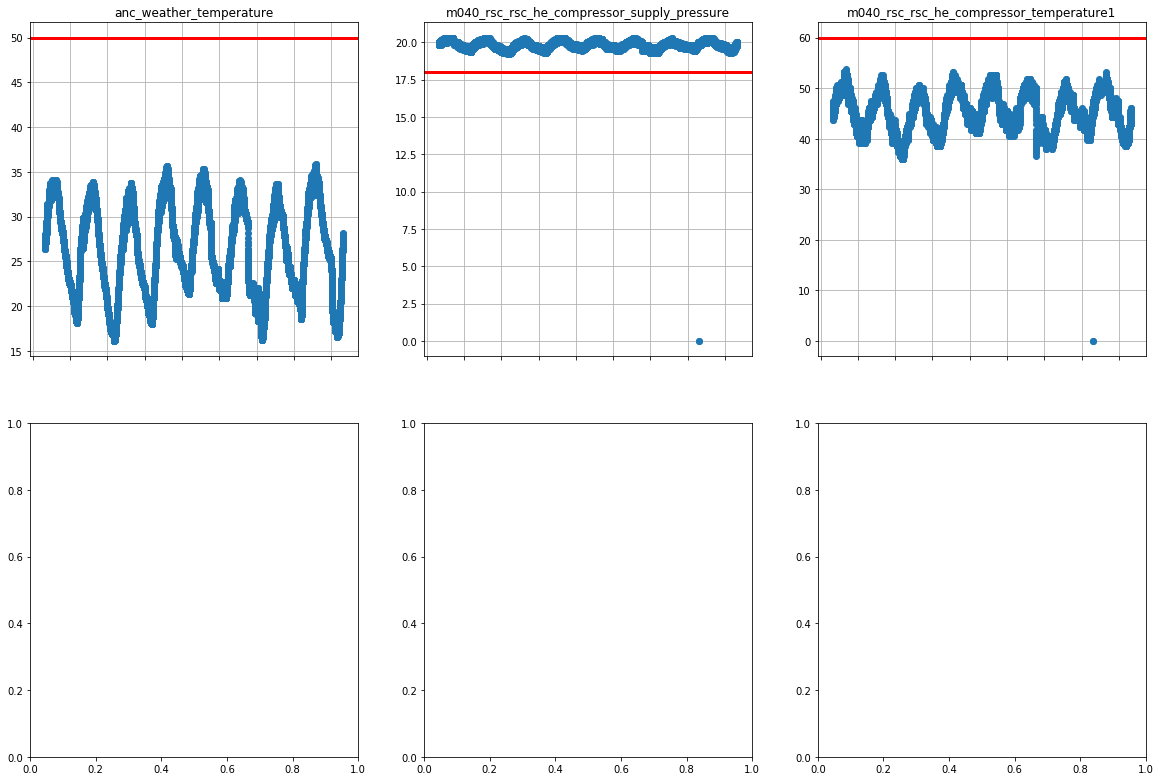

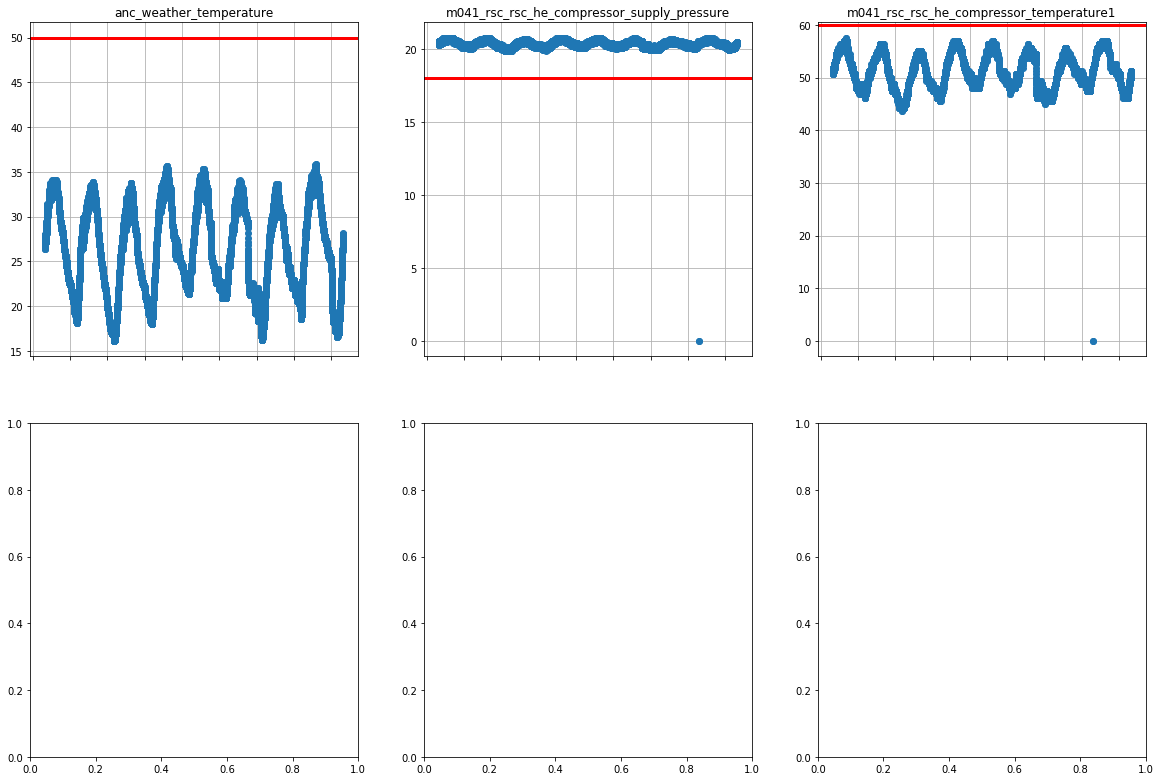

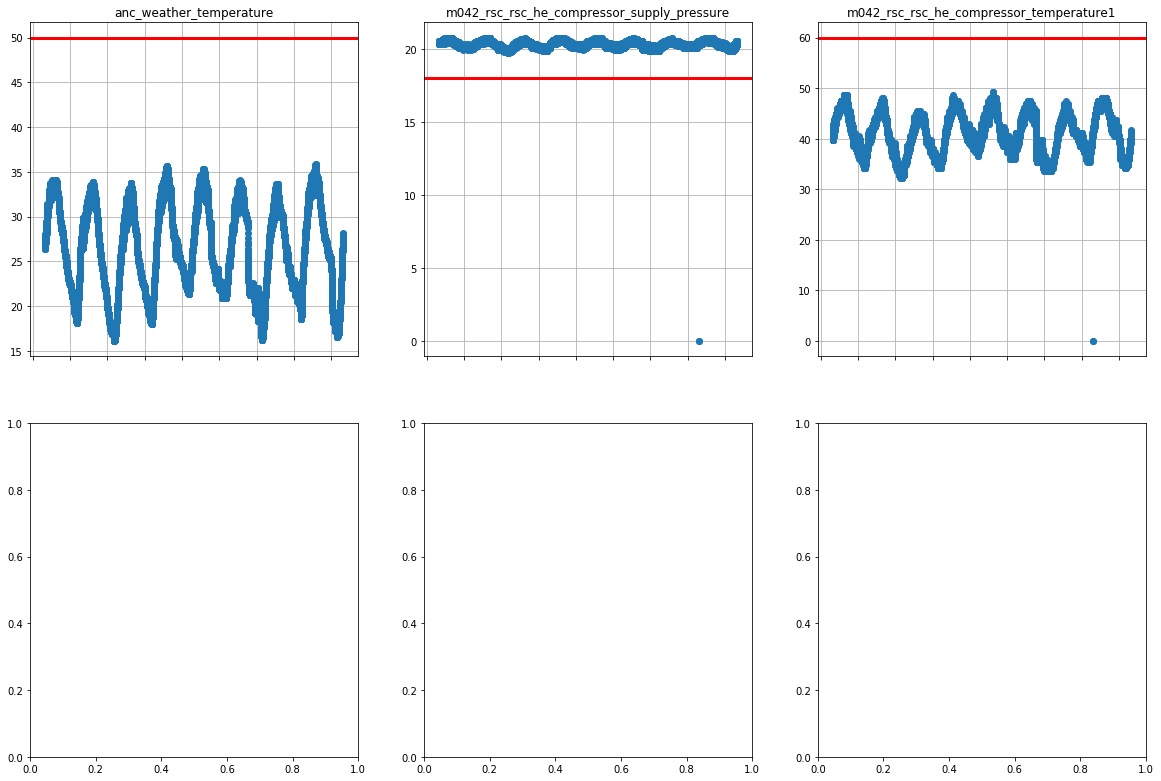

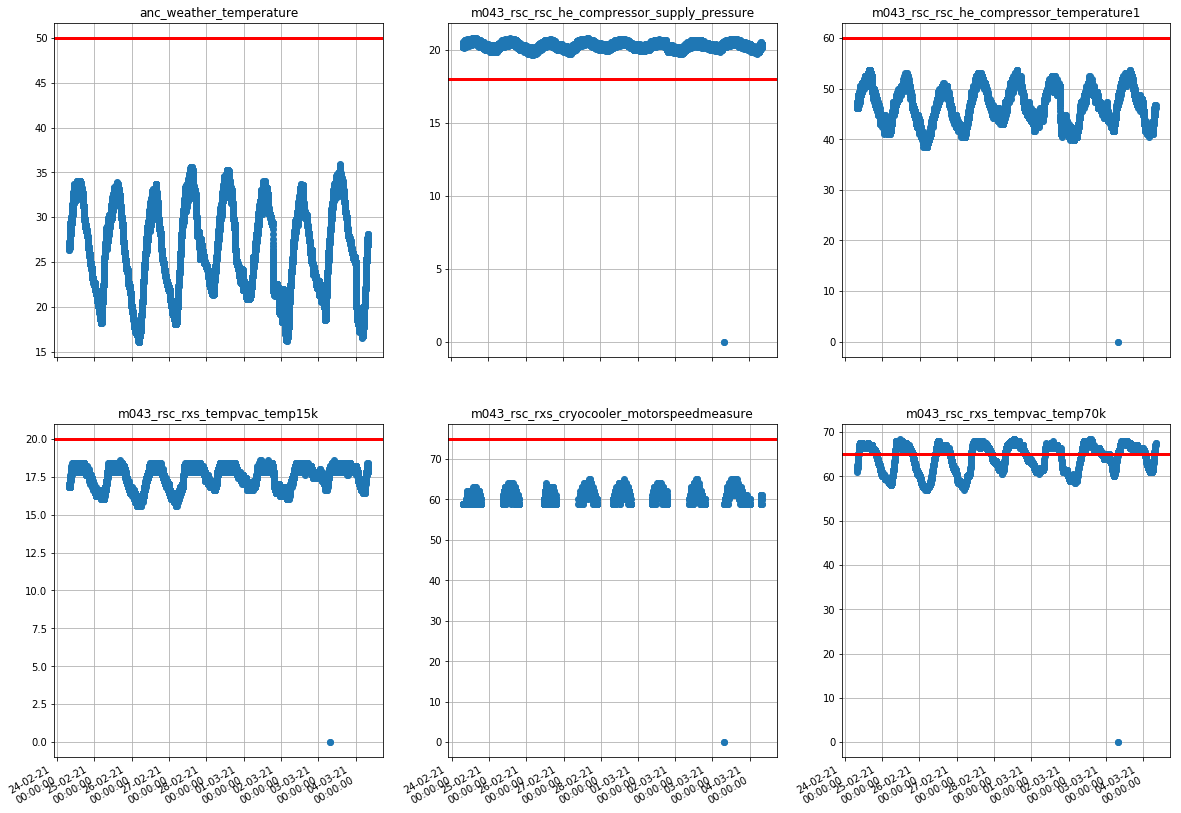

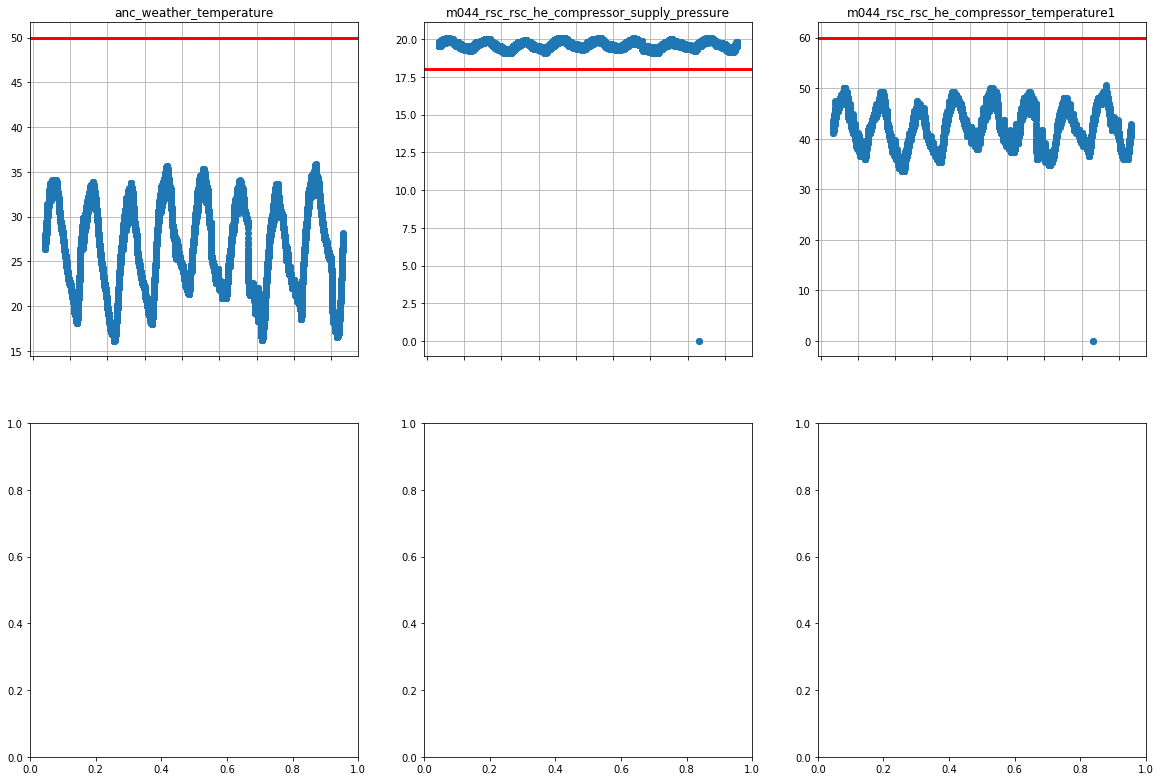

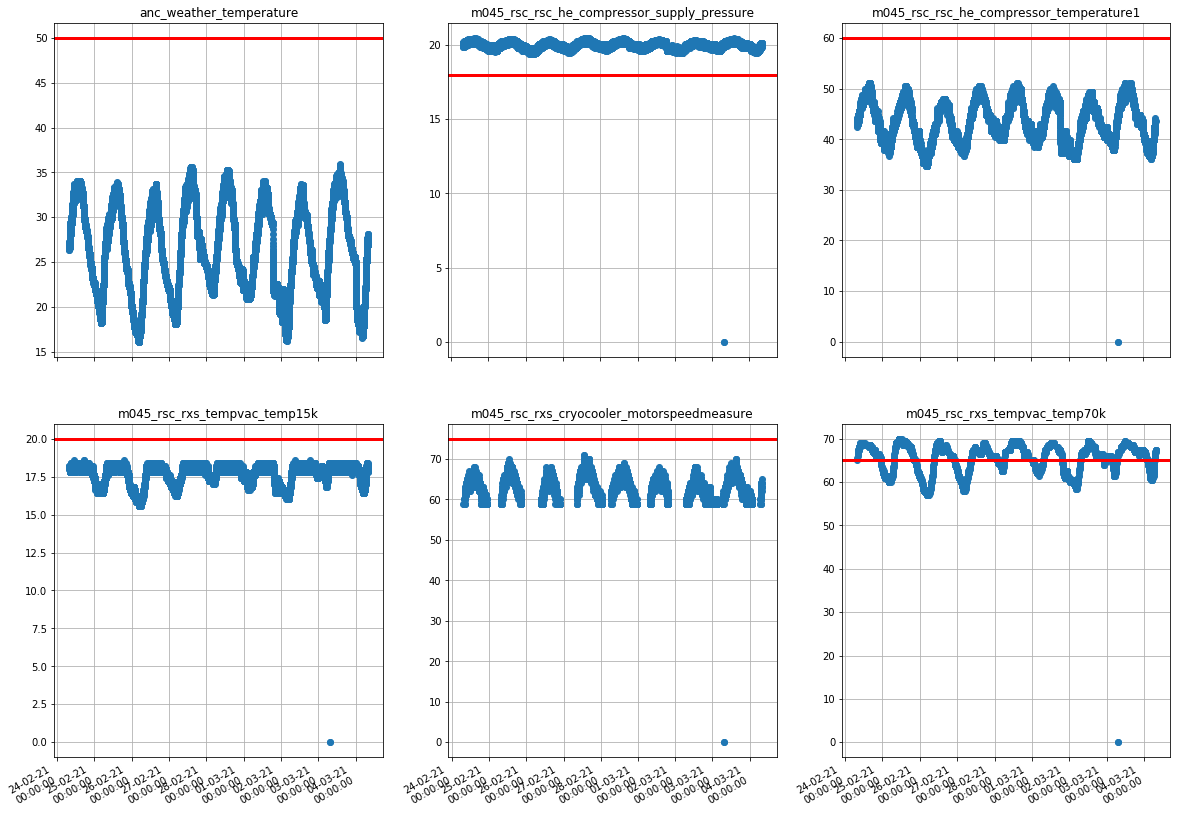

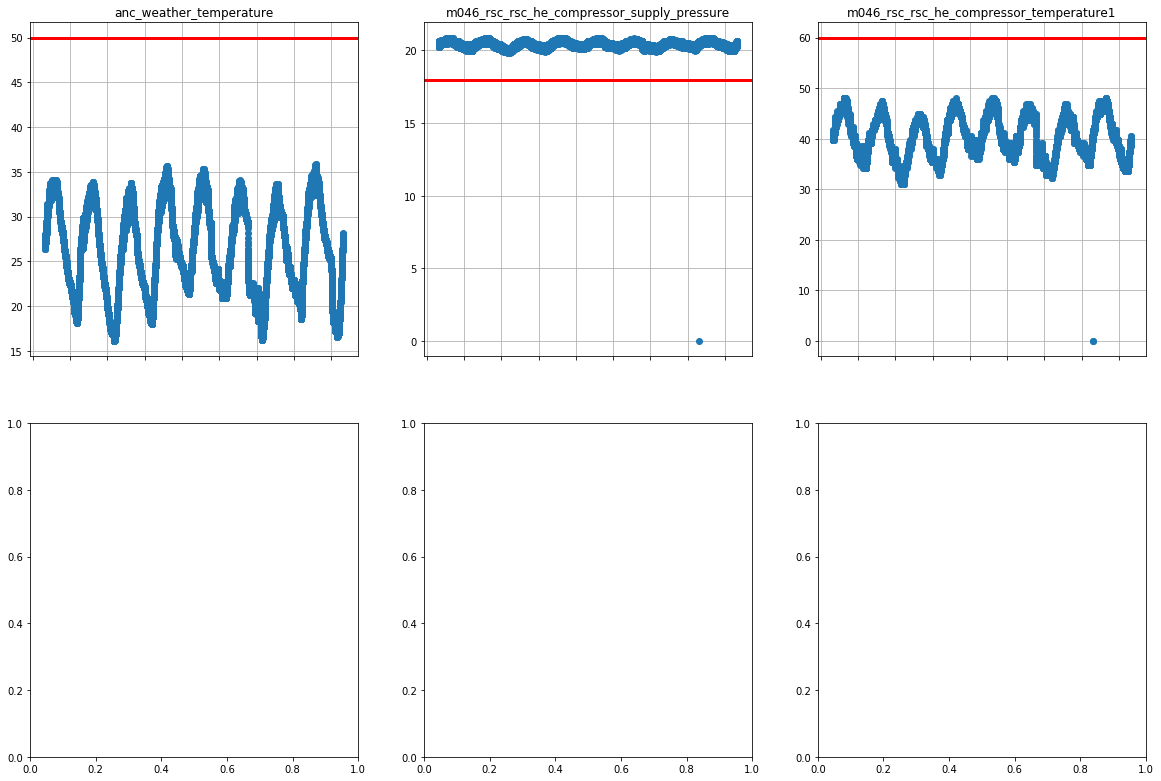

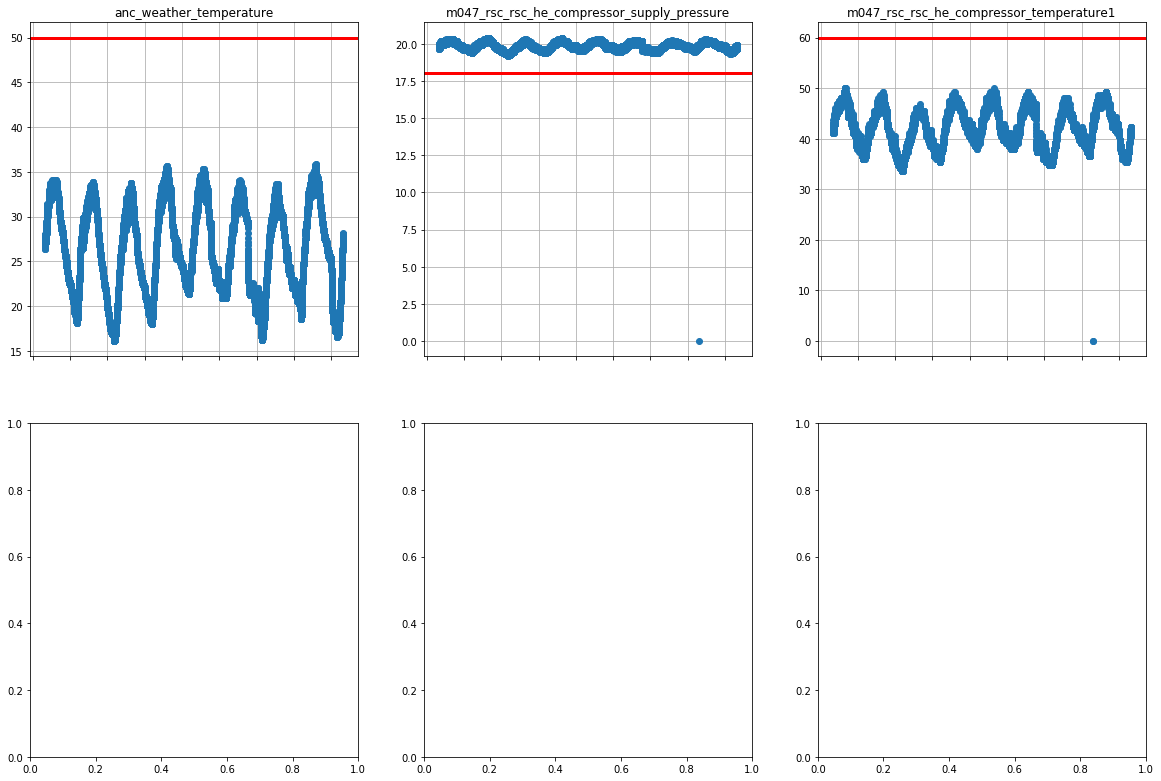

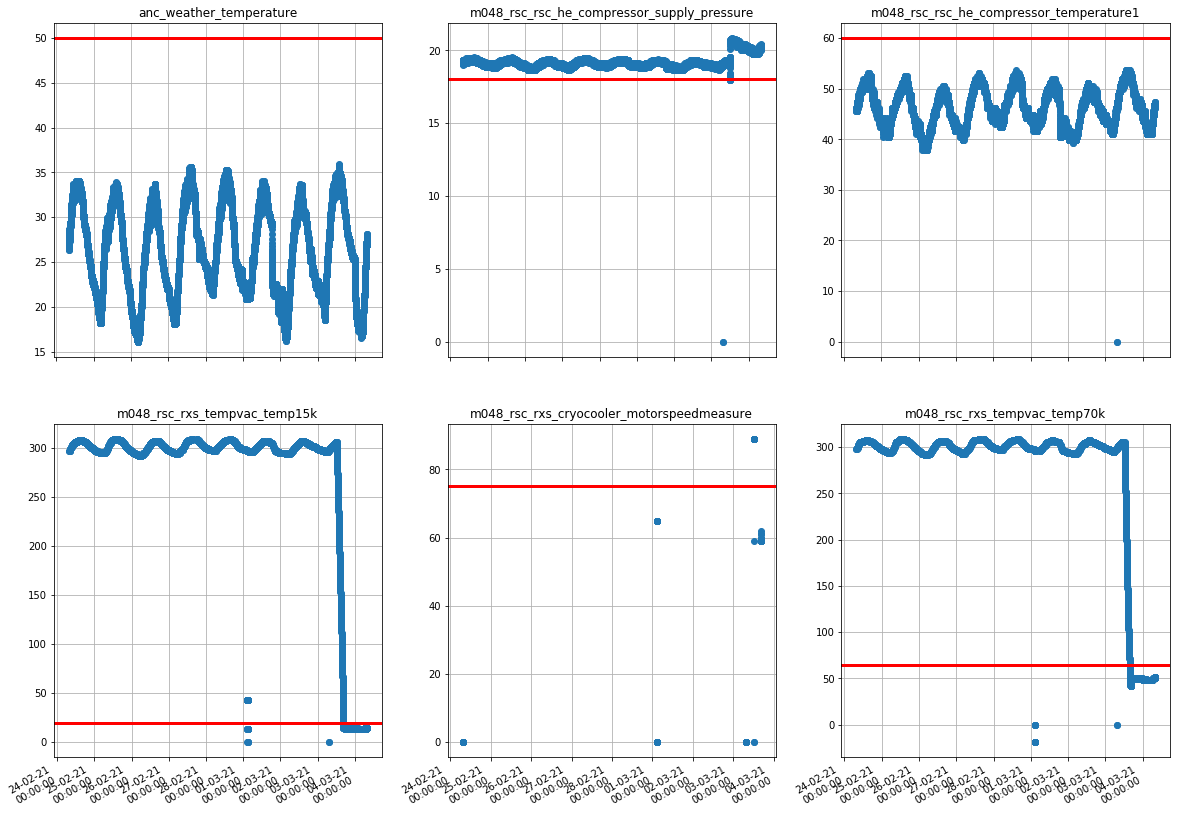

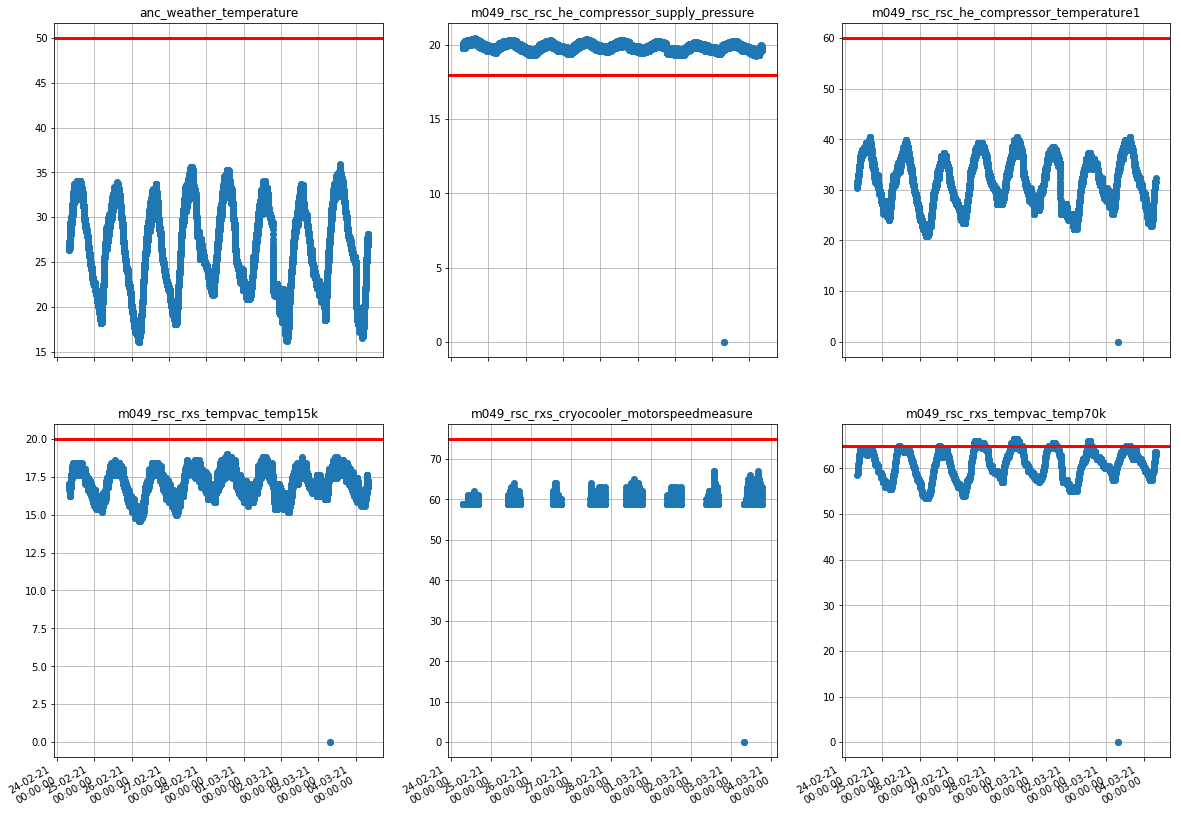

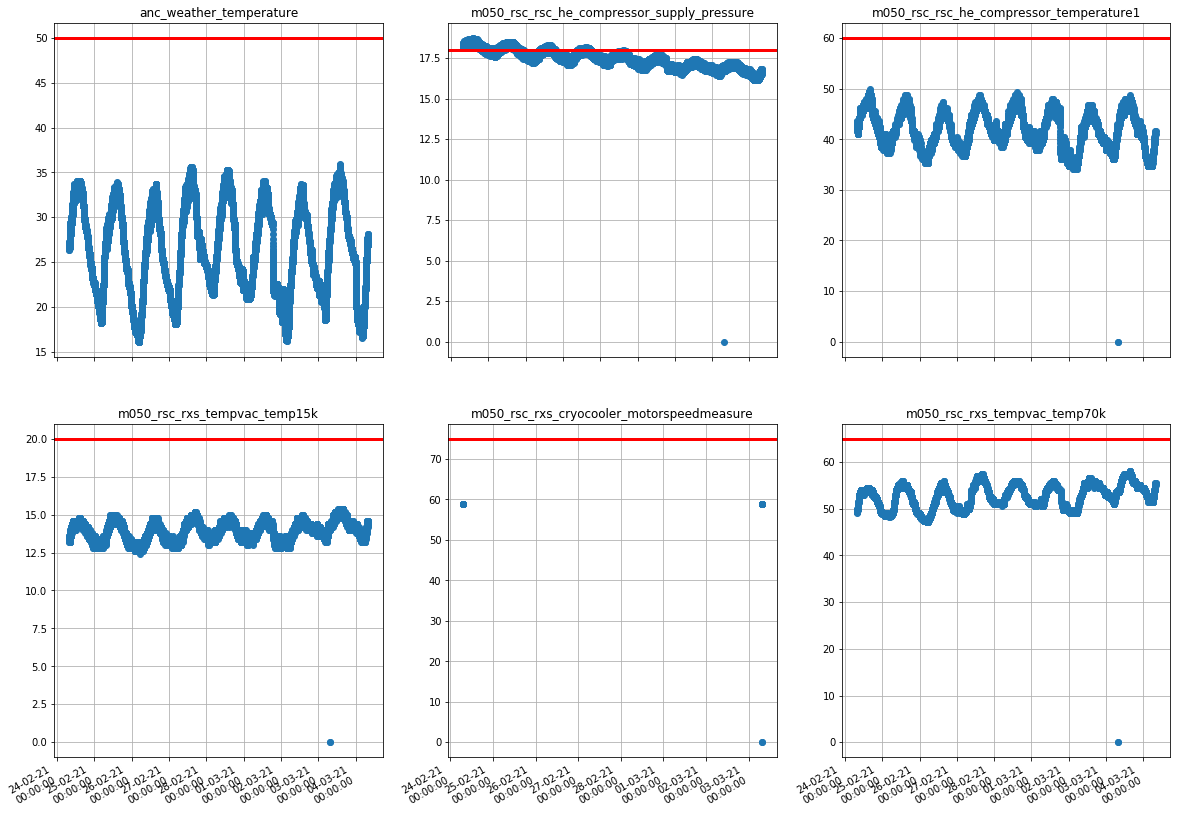

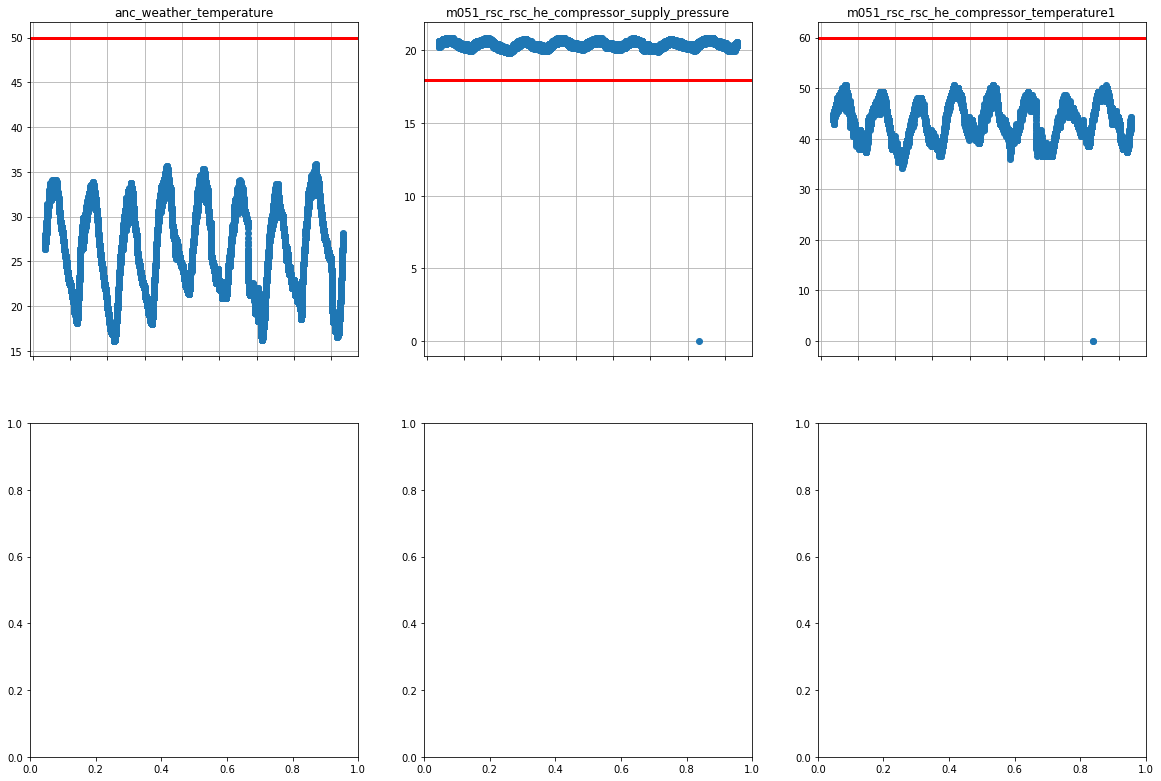

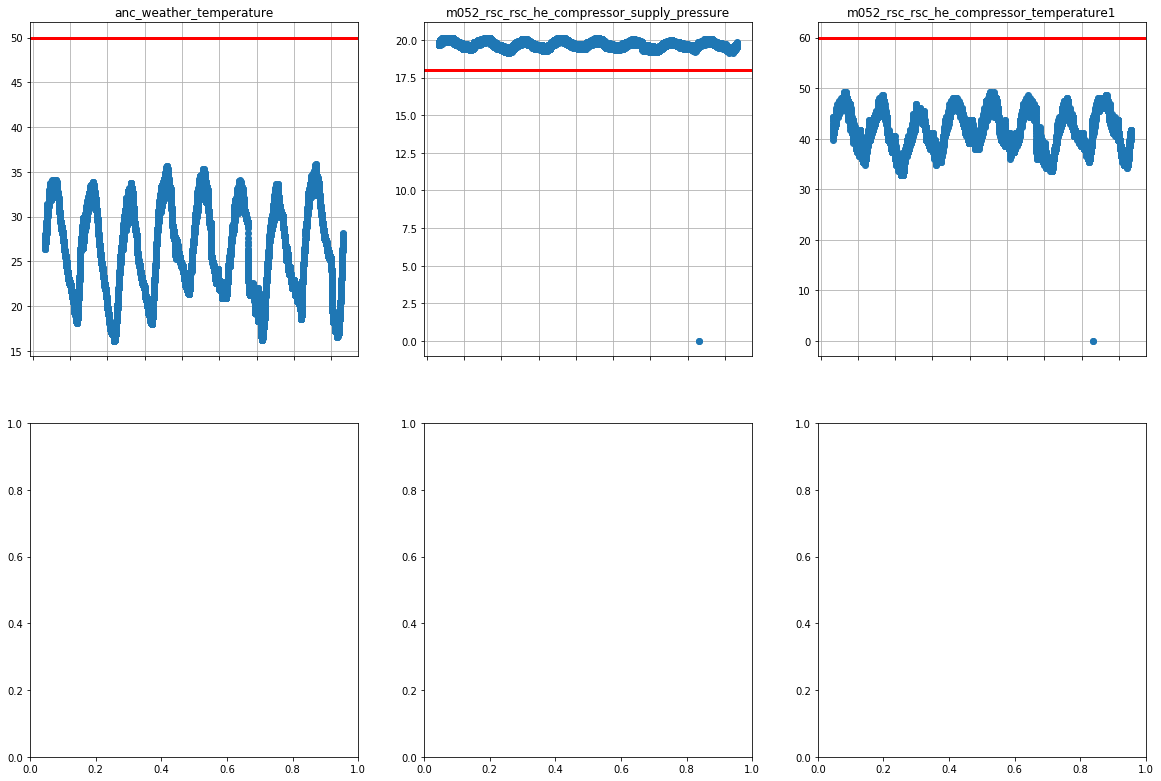

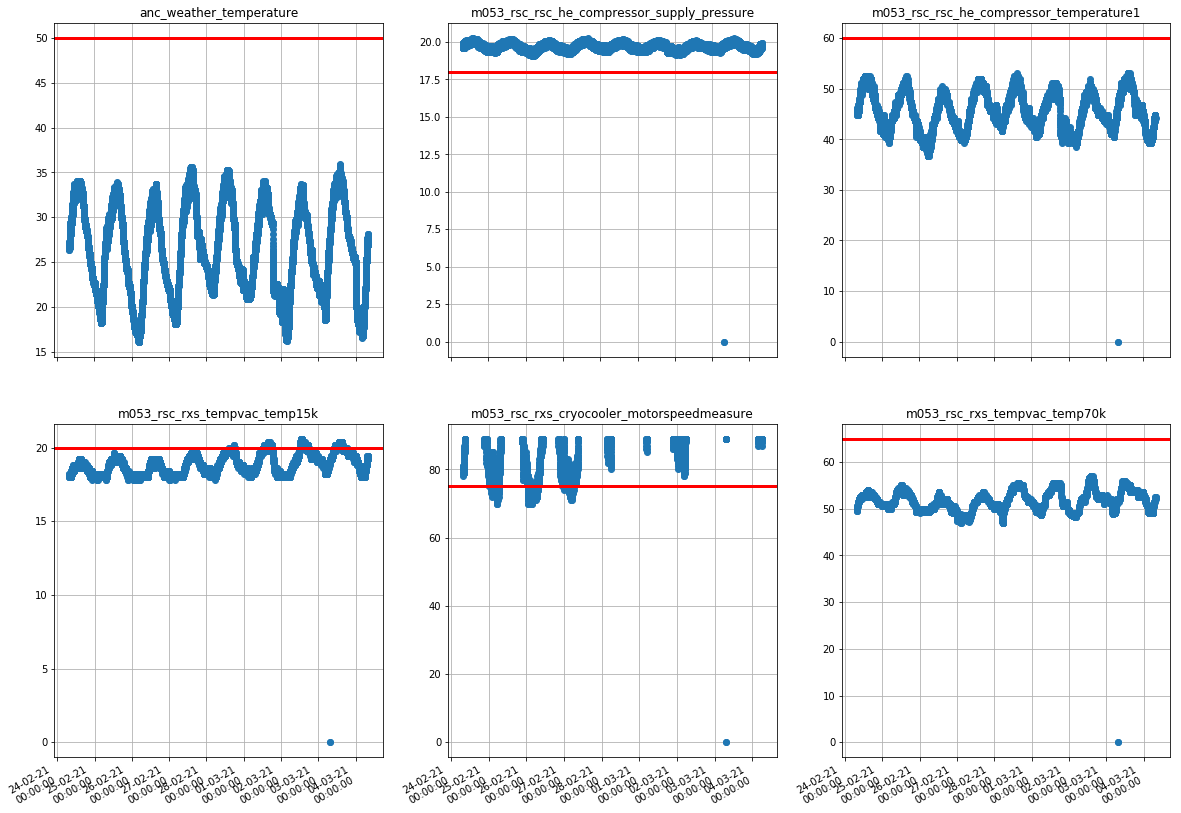

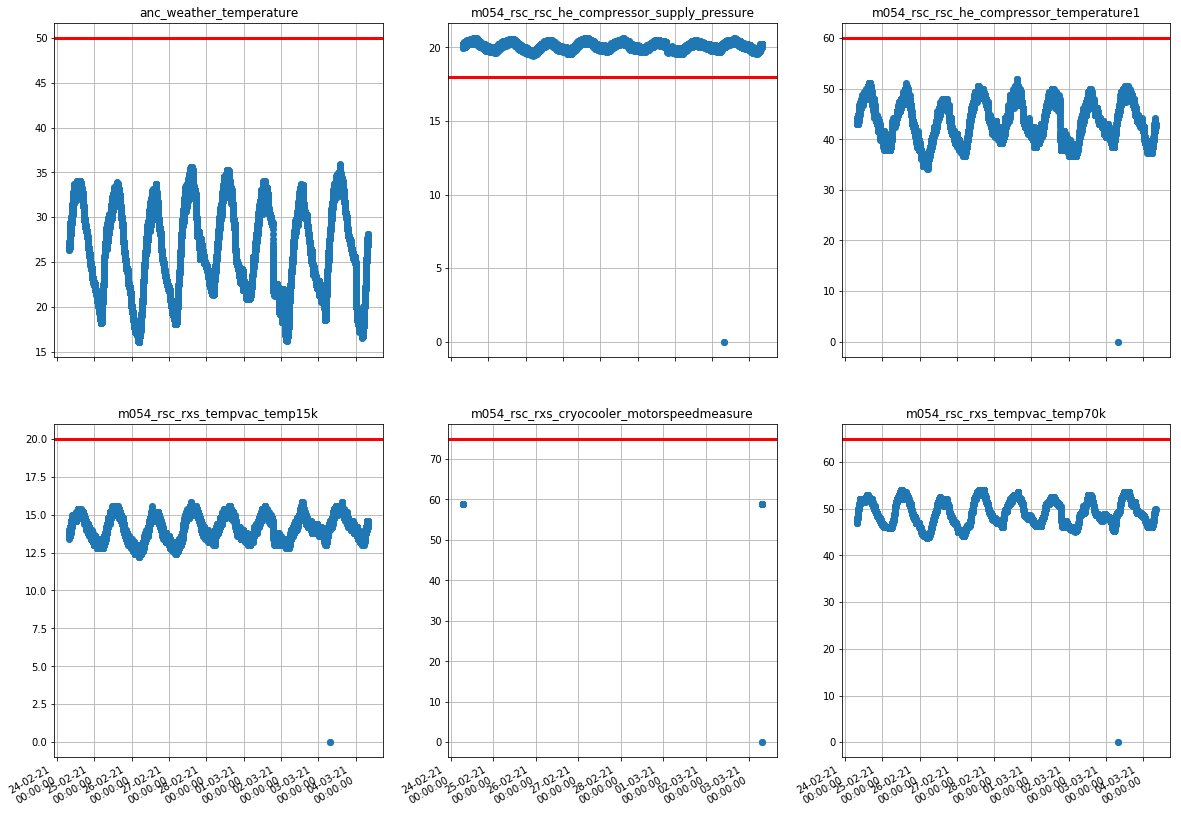

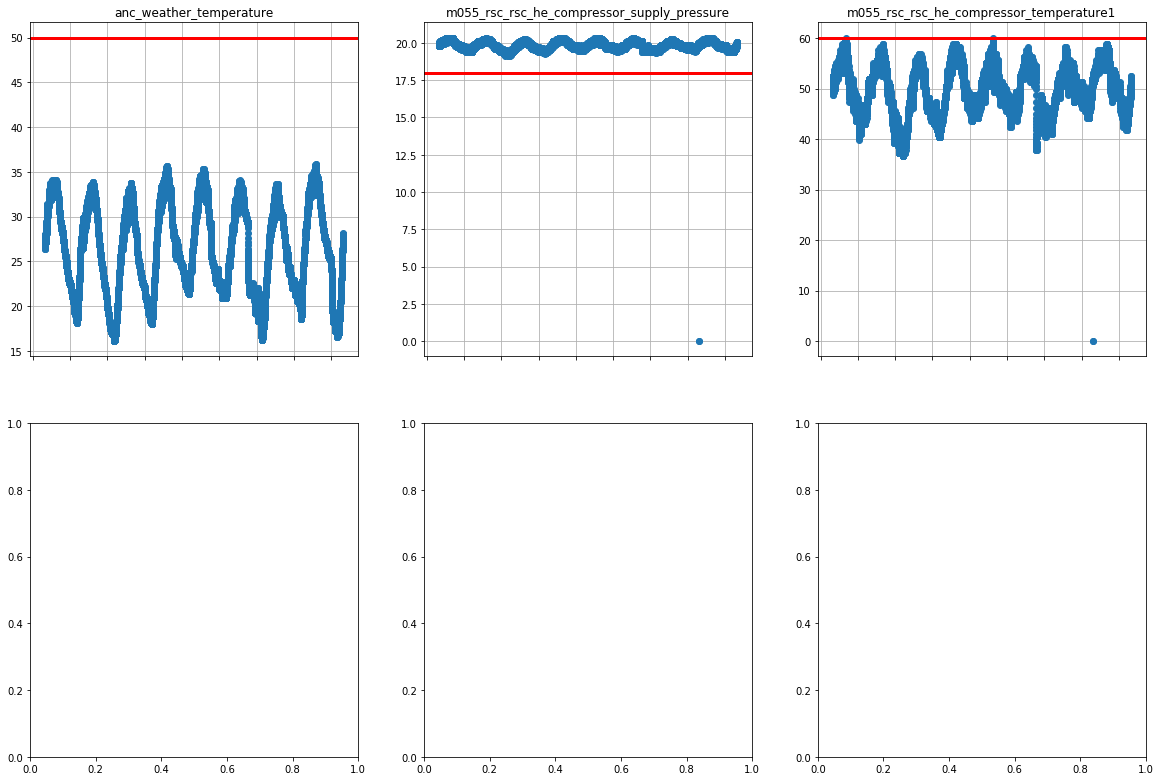

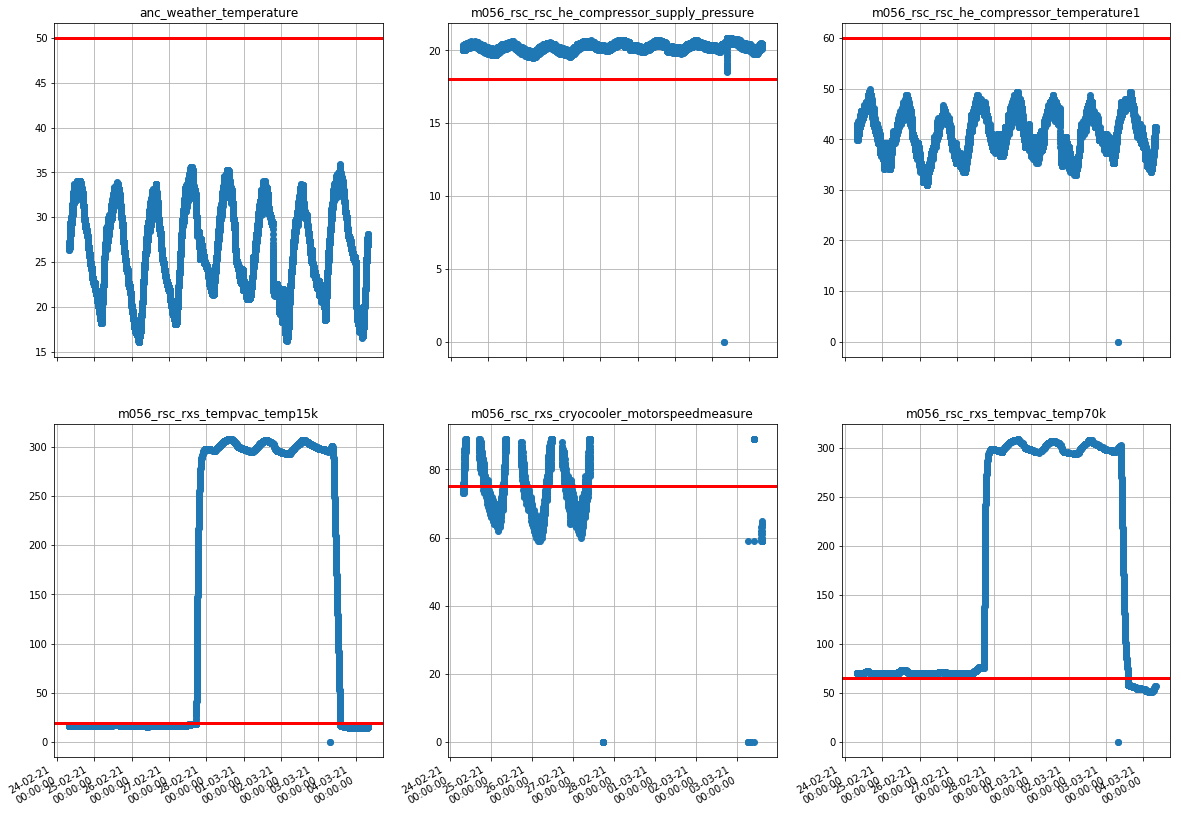

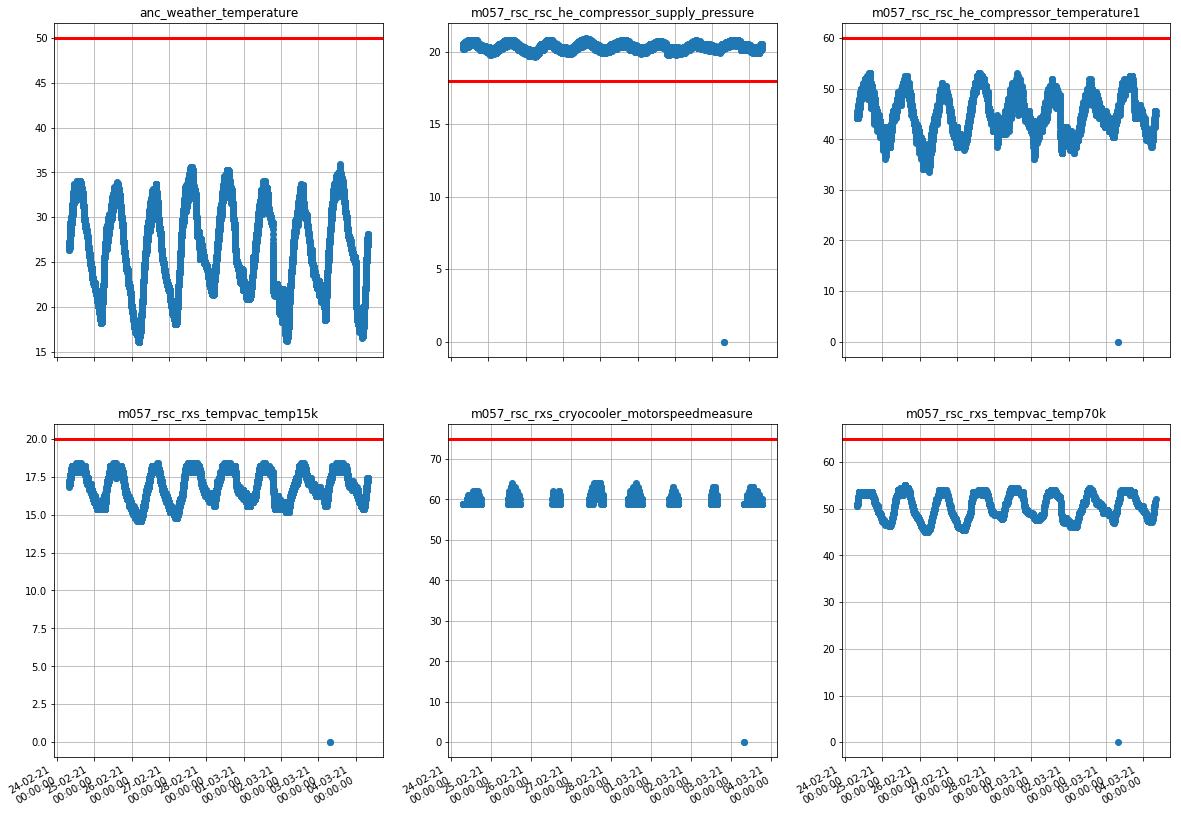

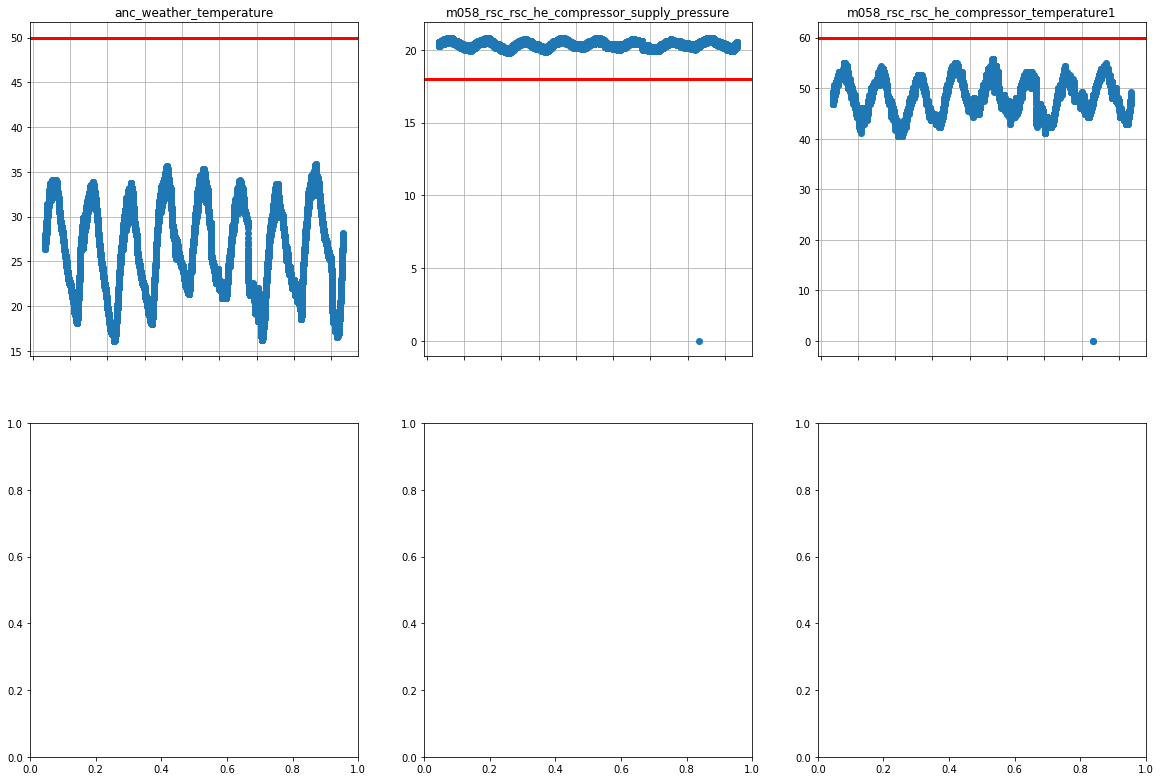

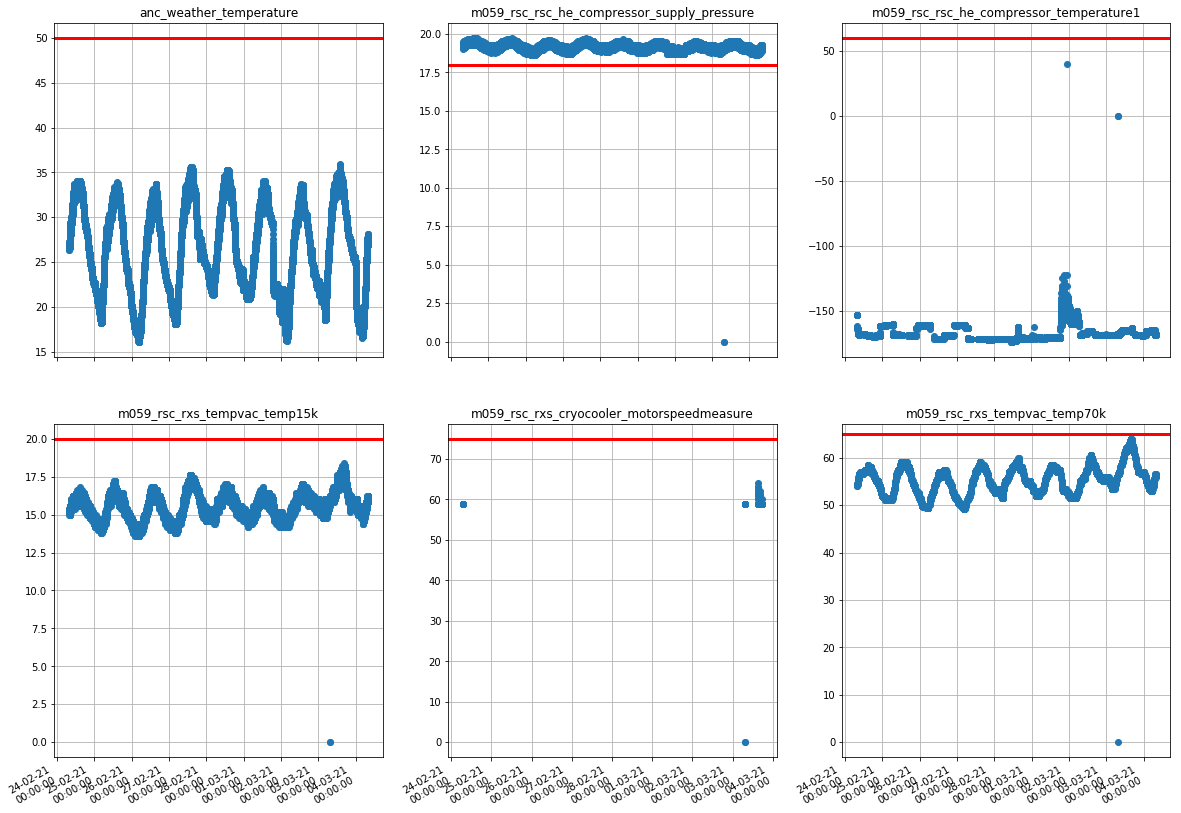

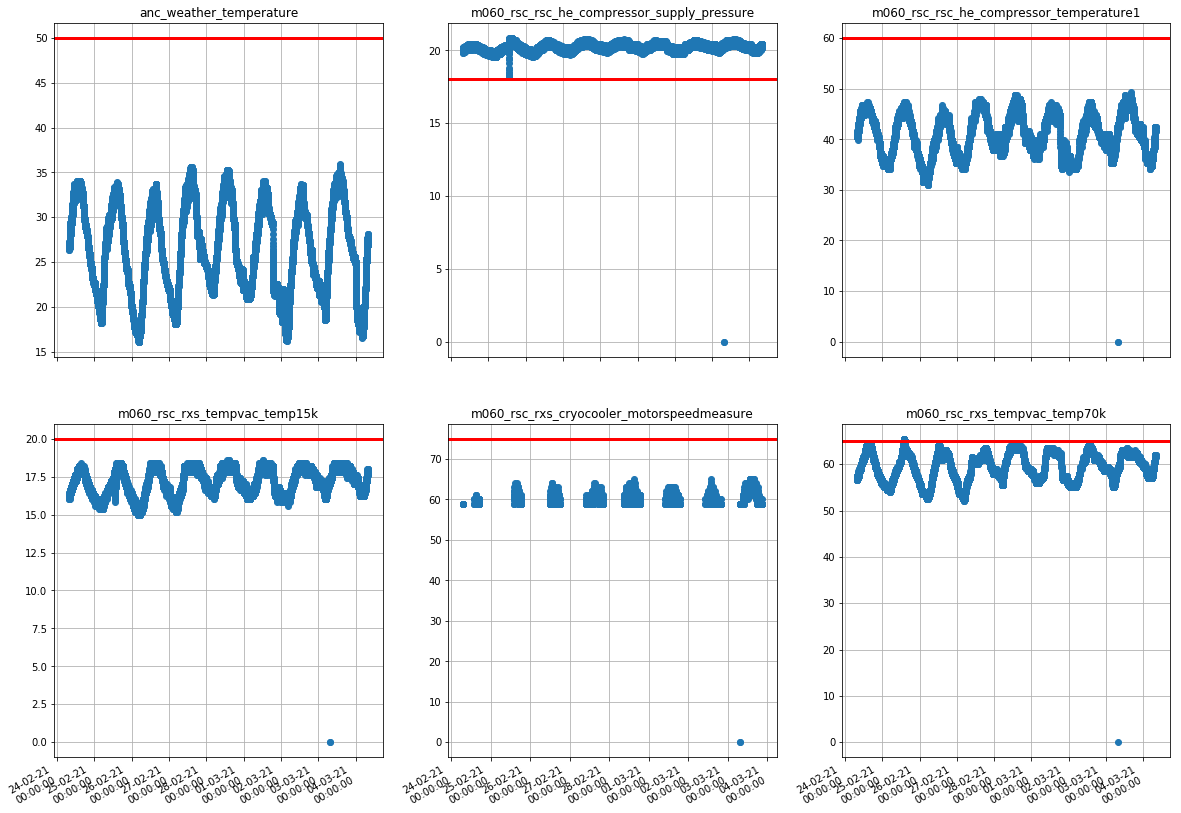

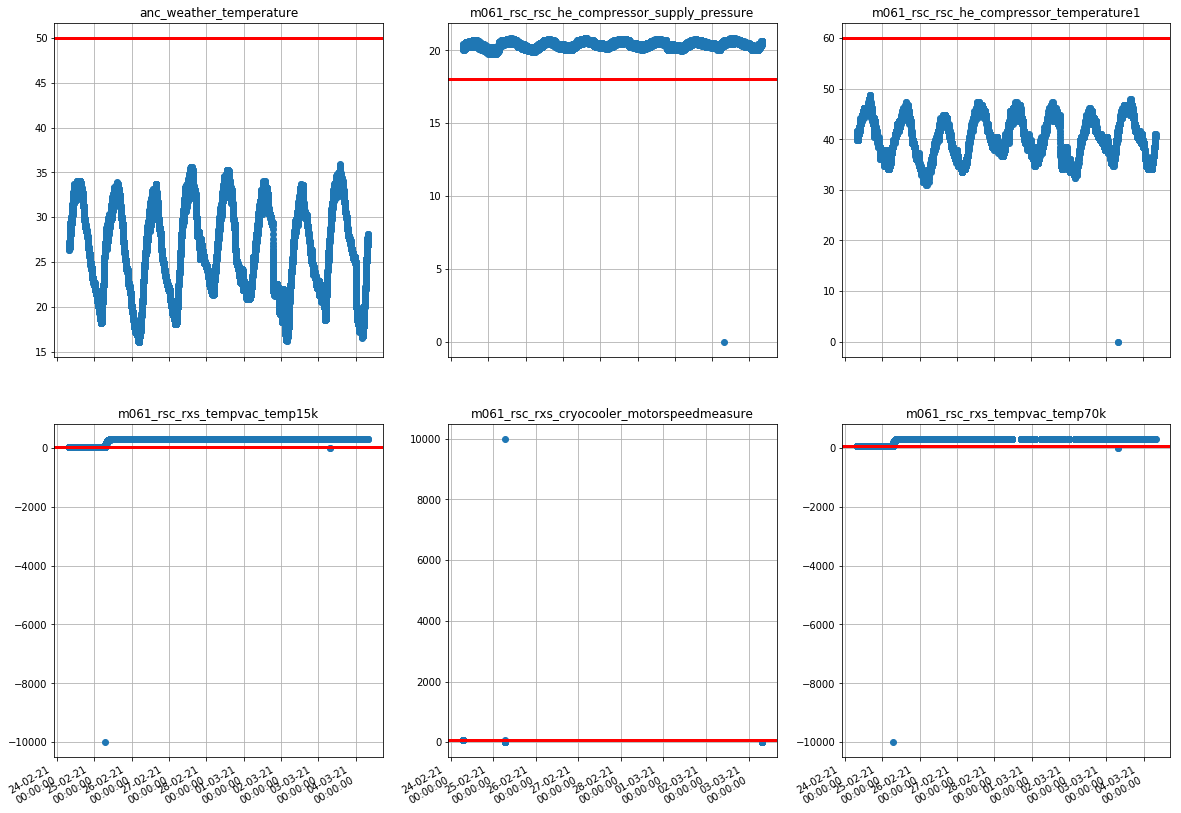

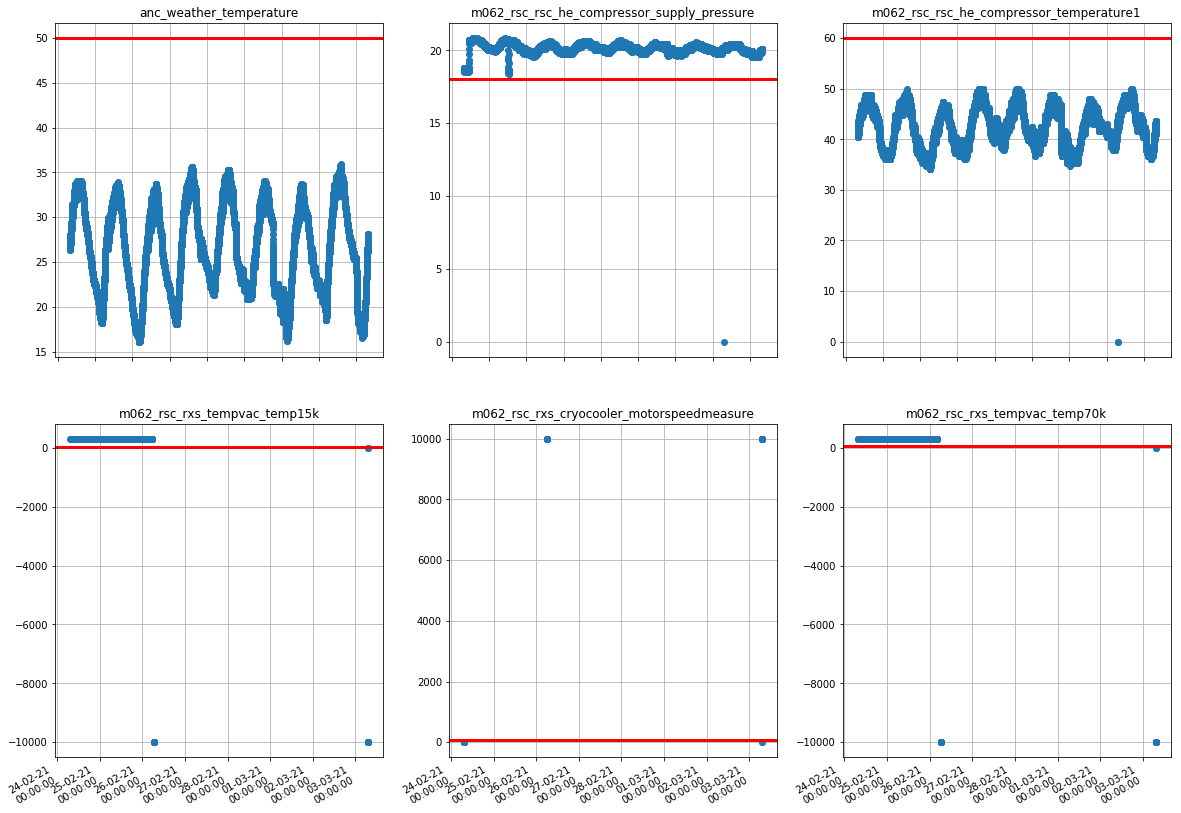

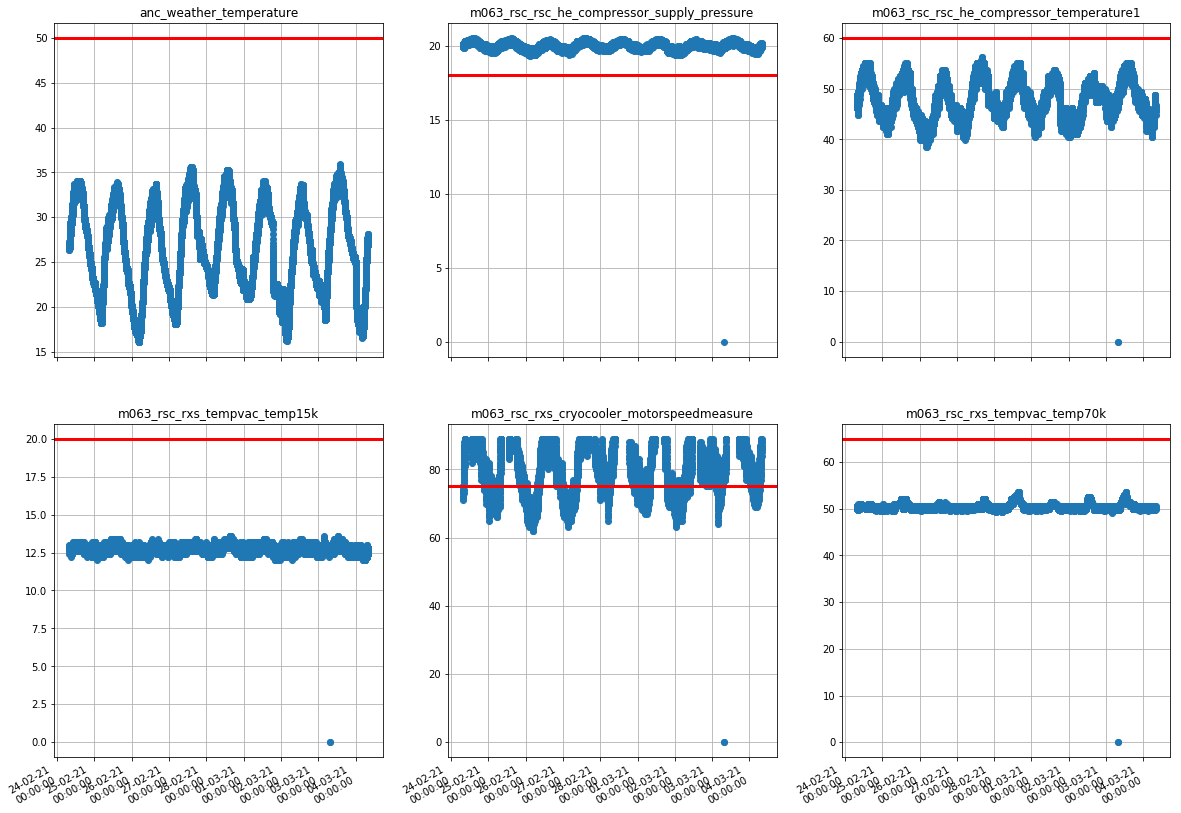

In [11]:
# Choose your xtick format string
date_fmt = '%d-%m-%y\n%H:%M:%S'

# Use a DateFormatter to set the data to the correct format.
date_formatter = DateFormatter(date_fmt)
        
for ap in aps:
    err_state = []
    for k in all_data[ap].iteritems():
        err_state.append(k[1]['err'])
    if any(err_state):
        figure(figsize=(20,15))
        for i,sensor in enumerate(sensors): 
            sen = '%s_%s'%(ap,sensor[0]) if sensor[0].startswith('rsc') else '%s'%(sensor[0])
            subplot(2,3,i+1)
            try:
                ts = all_data[ap][sensor[0]]['ts']
                data = all_data[ap][sensor[0]]['data']
            except:
                continue
            plot_date(matplotlib.dates.epoch2num(ts),data)
            title('%s'%(sen))
            ax = gca()
            axhline(sensor[1],color='r',linewidth=3)
            ax.xaxis.set_major_formatter(date_formatter)#ax.figure.autofmt_xdate()
            ax.figure.autofmt_xdate()
            grid()
    print ap

In [12]:
now = time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime(time.time()))
def_start = katpoint.Timestamp(time.time()-48*3600)
def_end = katpoint.Timestamp(now)


all_data = {}        
for ap in rts:
    all_data[ap] = {}
    st =  time.time()
    len_rec = 0
    for i,sensor in enumerate(sensors): 
        sen = '%s_%s'%(ap,sensor[0]) if sensor[0].startswith('rsc') else '%s'%(sensor[0]) 
        if sen.startswith('anc'):
            sen = 'anc_air_temperature'
        
        params={'sensor': sen,  # name of the sensor.
           'start_time':def_start.secs, # start time in seconds - float should work.
           'end_time': def_end.secs, # end time in seconds
           'limit':1000000,
           'include_value_time': True}
        for t in range(10):
            try:
                res = requests.get(url_rts, params,timeout=200) # Make the call.
            except Exception as e:
                print e
                print "Retrying"
                continue
            break
        res.close()
        if  res.status_code != 200: 
            continue
        len_rec += len(res.json()['data'])
        data_list = [(r['value_time'], r['value']) for r in res.json()['data']]
        data = array(data_list)
        if len(data) !=0:
            err = any(data[:,1] >= sensor[1]) if sensor[2] == 'gt' else any(data[:,1] <= sensor[1])
            all_data[ap][sensor[0]] = {'ts':data[:,0],'data':data[:,1],'err':err}
    ed =  time.time()
    print "%s processed in %.2f seconds with %d records at %s"%(ap,ed-st,len_rec,time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime(time.time())))

In [13]:
# Choose your xtick format string
date_fmt = '%d-%m-%y\n%H:%M:%S'

# Use a DateFormatter to set the data to the correct format.
date_formatter = DateFormatter(date_fmt)
        
for ap in rts:
    err_state = []
    for k in all_data[ap].iteritems():
        err_state.append(k[1]['err'])
    if any(err_state):
        figure(figsize=(20,15))
        for i,sensor in enumerate(sensors): 
            sen = '%s_%s'%(ap,sensor[0]) if sensor[0].startswith('rsc') else '%s'%(sensor[0])
            subplot(2,3,i+1)
            try:
                ts = all_data[ap][sensor[0]]['ts']
                data = all_data[ap][sensor[0]]['data']
            except:
                continue
            plot_date(matplotlib.dates.epoch2num(ts),data)
            title('%s'%(sen))
            ax = gca()
            axhline(sensor[1],color='r',linewidth=3)
            ax.xaxis.set_major_formatter(date_formatter)#ax.figure.autofmt_xdate()
            ax.figure.autofmt_xdate()
            grid()
    print ap